# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
hs_genes = genes_dict77['human']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


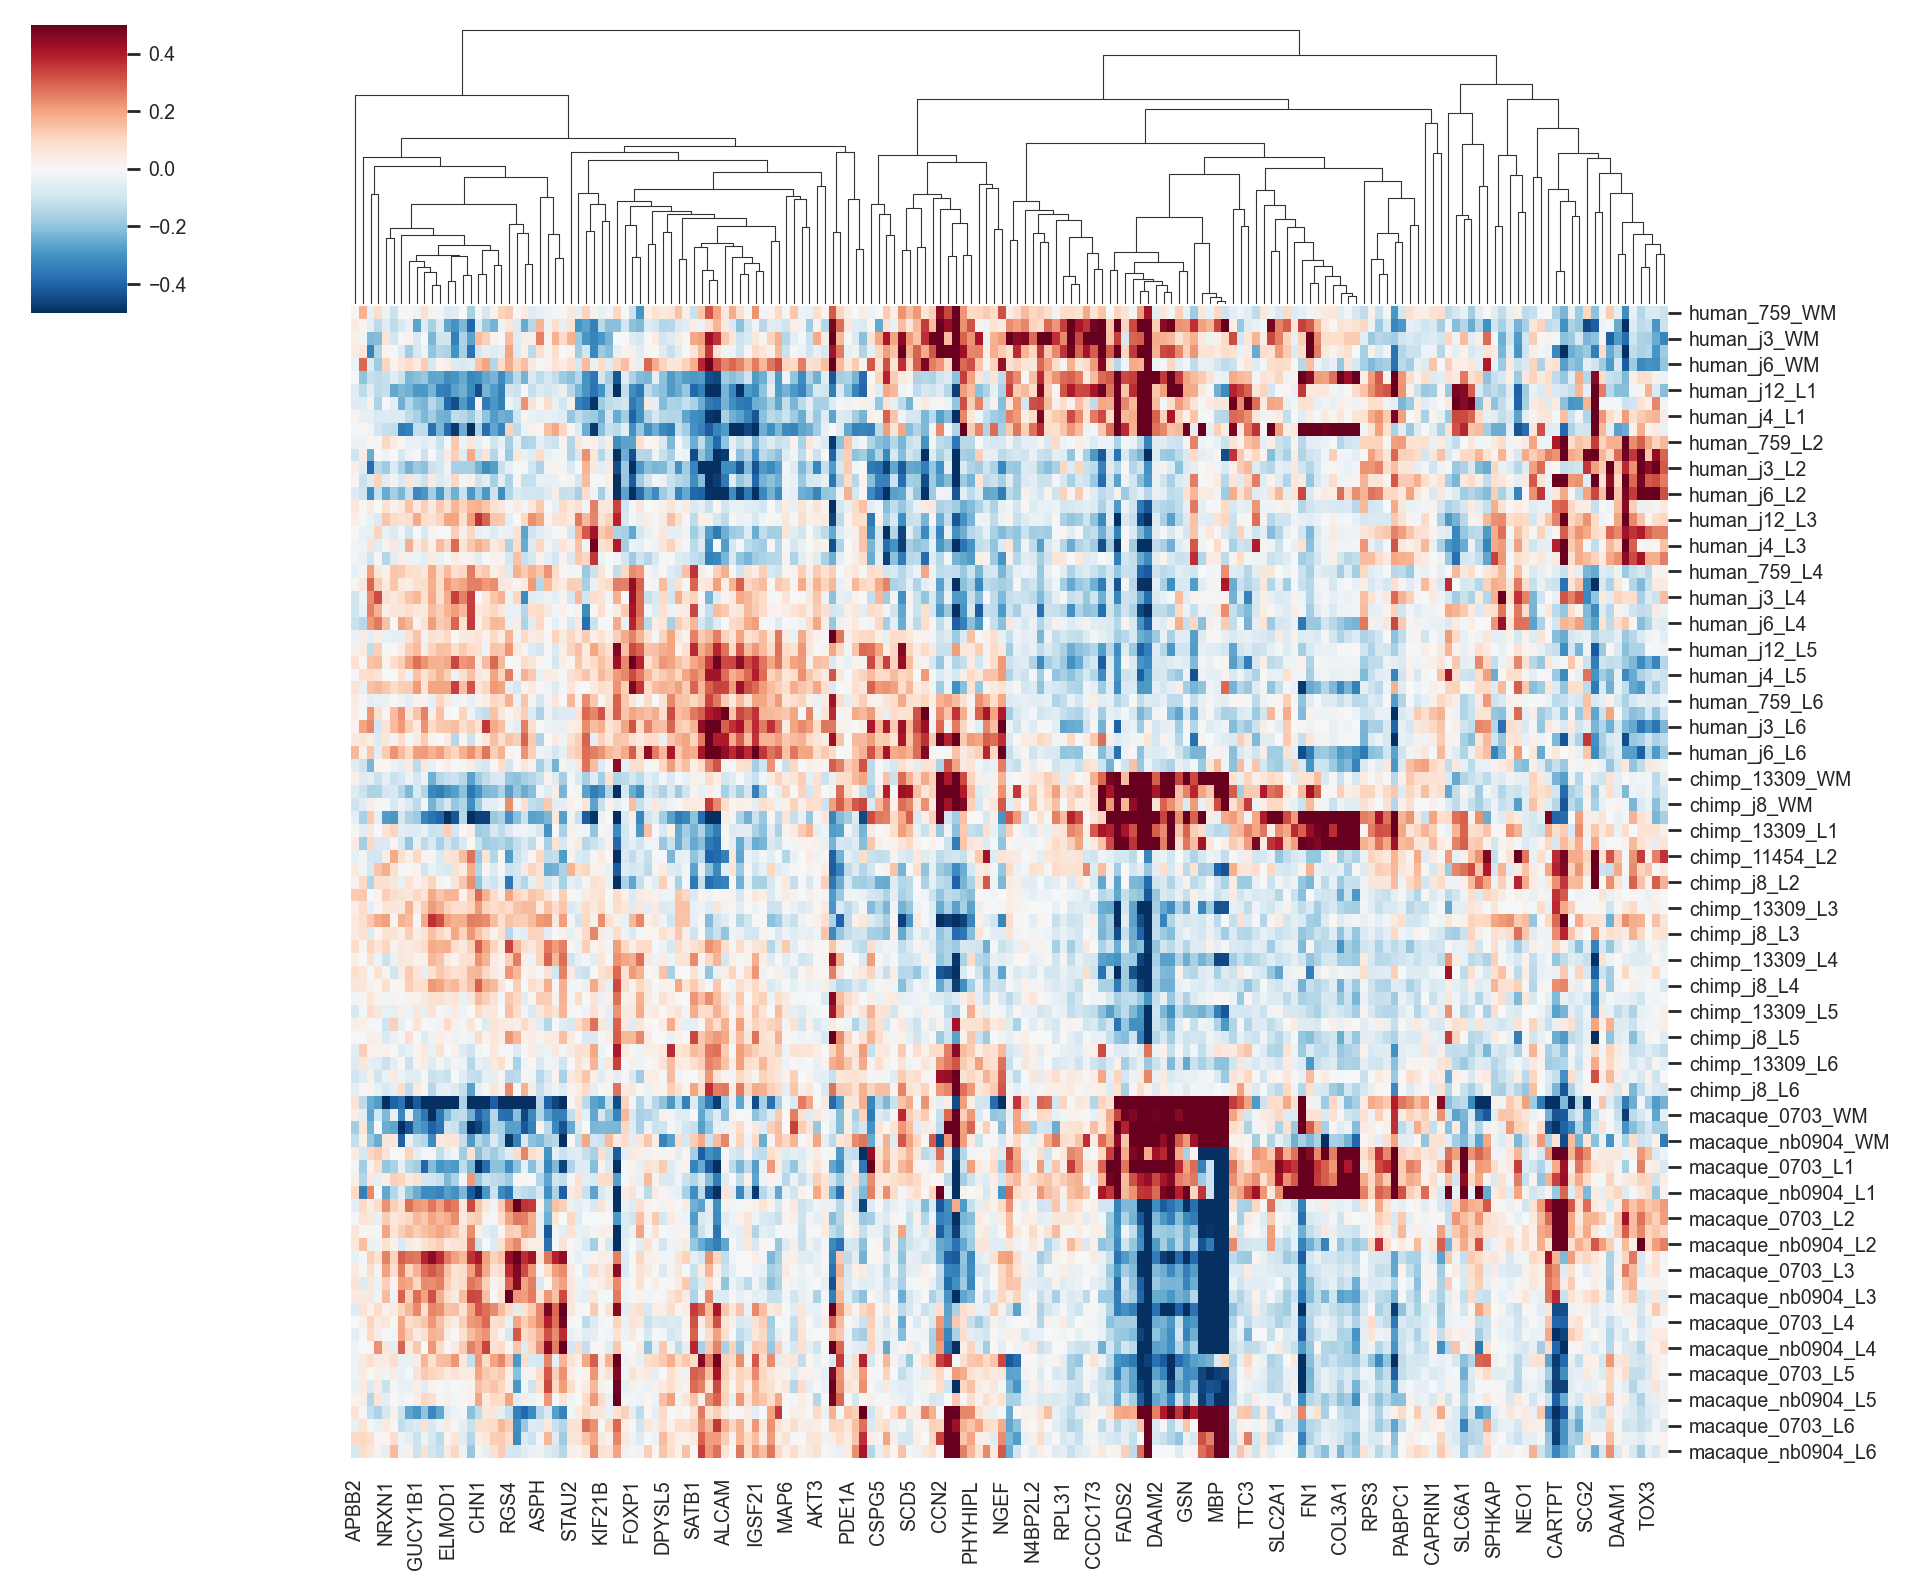

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Agglomerative clusterisation

In [19]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.T, metric='cosine') + 1
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(df_hs.T)

AgglomerativeClustering(n_clusters=4)

In [20]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [21]:
labels.to_csv('./results/human_clusters_50.csv')

In [22]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [23]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

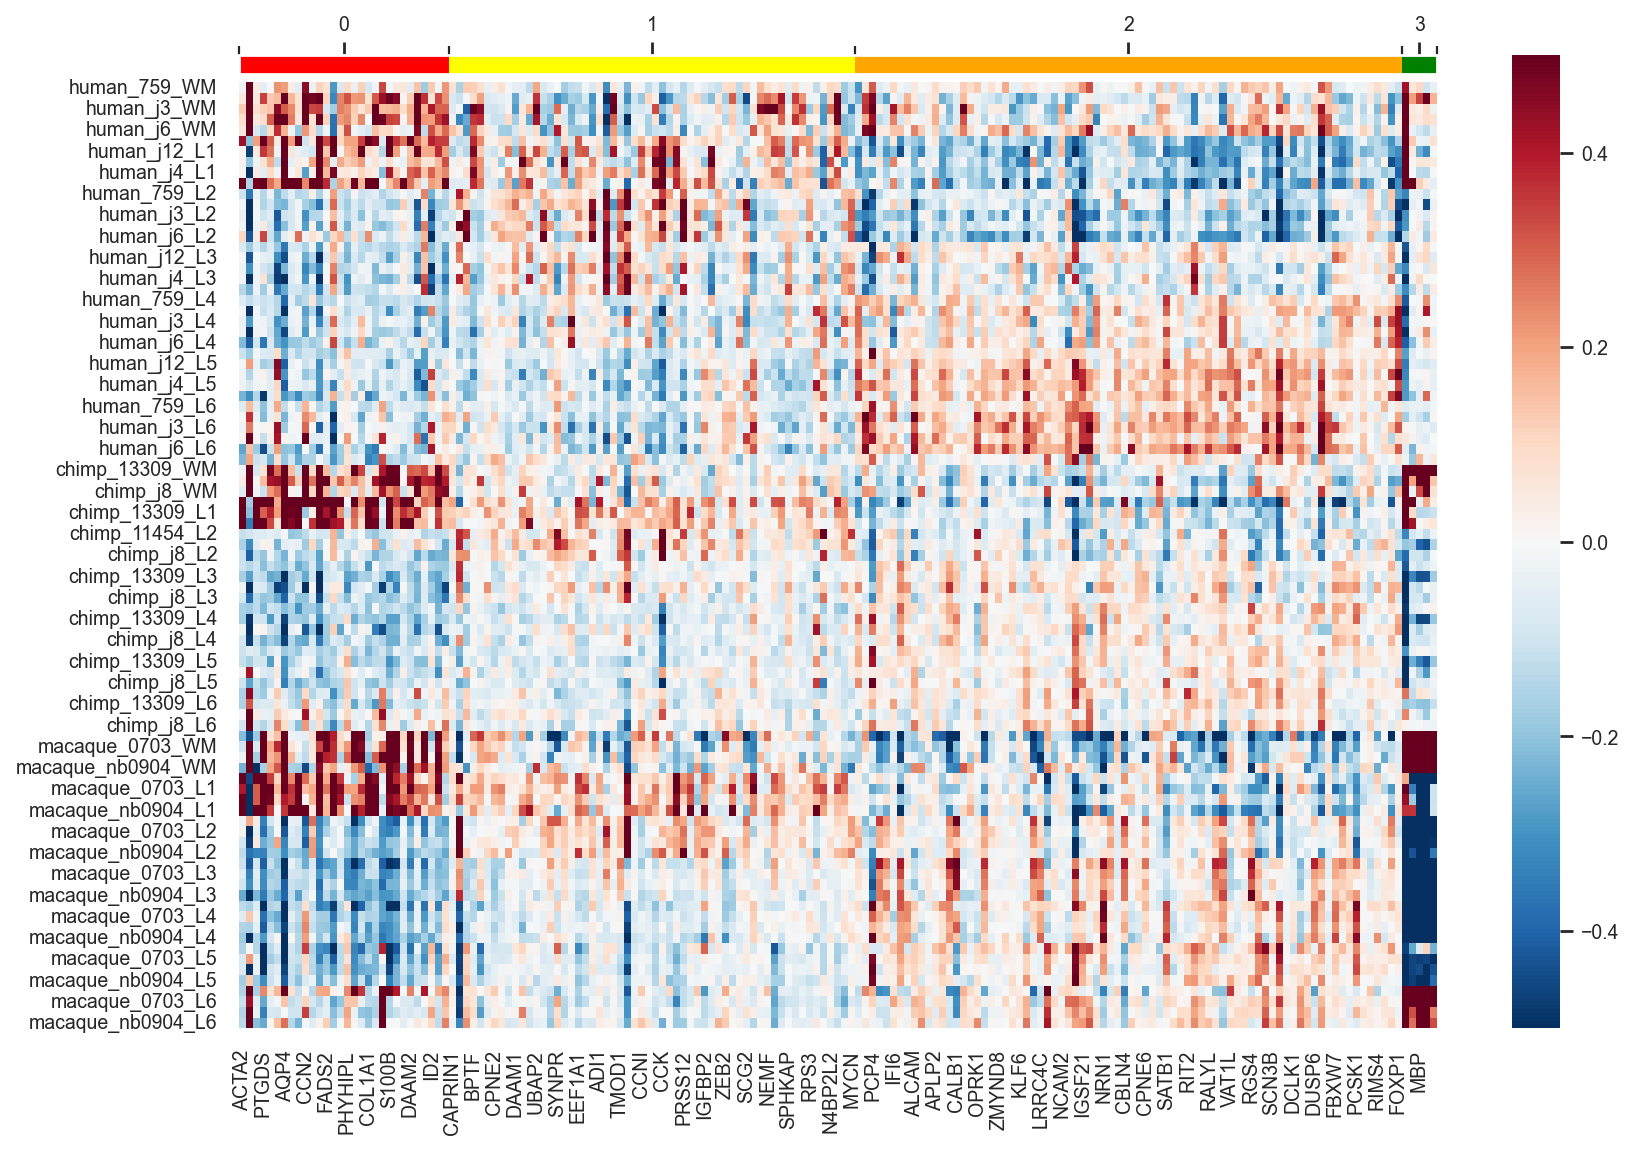

In [24]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [25]:
labels[labels == 1].size

58

## Cluster profiles (mean)

In [26]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [27]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTA2      ADI1      AKT3     ALCAM      ANK2     APBB2  \
condition layer                                                               
chimp     L1     0.728220  0.232106 -0.012988  0.009130 -0.074303  0.000521   
          L2    -0.127487 -0.029761 -0.013202 -0.242804 -0.107423  0.009758   
          L3    -0.095616 -0.081698  0.004795 -0.066325 -0.046509  0.064595   
          L4    -0.111591 -0.069586 -0.005160  0.006249 -0.037624  0.065062   
          L5    -0.077636 -0.055009 -0.032334  0.134409 -0.015614 -0.020785   

                   APCDD1     APLP2       APP      AQP4  ...      TSPO  \
condition layer                                          ...             
chimp     L1     0.438053 -0.006447 -0.143722  0.764710  ...  0.040045   
          L2    -0.015450 -0.034986 -0.104327 -0.096835  ... -0.052895   
          L3    -0.180579 -0.042810  0.091190 -0.409157  ... -0.039607   
          L4    -0.162720 -0.058964  0.091682 -0.409665  ... -0.063044   
          L5    -0.139614  0.015875  0.062882 -0.282063  ... -0.015141   

                     TTC3     TTYH1    TUBA4A     UBAP2     VAT1L    VSTM2A  \
condition layer                                                               
chimp     L1     0.146501  0.071092 -0.190006  0.001697 -0.134595  0.077321   
          L2    -0.025527  0.014022 -0.271730  0.053347 -0.027984  0.210841   
          L3    -0.097487  0.005924 -0.212395 -0.041216 -0.090556  0.094489   
          L4    -0.118147 -0.032925  0.030377  0.017843 -0.019777  0.014245   
          L5    -0.079551 -0.050280  0.149852 -0.056467  0.138460 -0.087230   

                   ZBTB18      ZEB2    ZMYND8  
condition layer                                
chimp     L1    -0.154330  0.037896 -0.001521  
          L2     0.229193  0.051170  0.059591  
          L3     0.178206 -0.040480  0.063579  
          L4     0.129230 -0.075607  0.019230  
          L5     0.023022 -0.057856 -0.050828  

[5 rows x 171 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

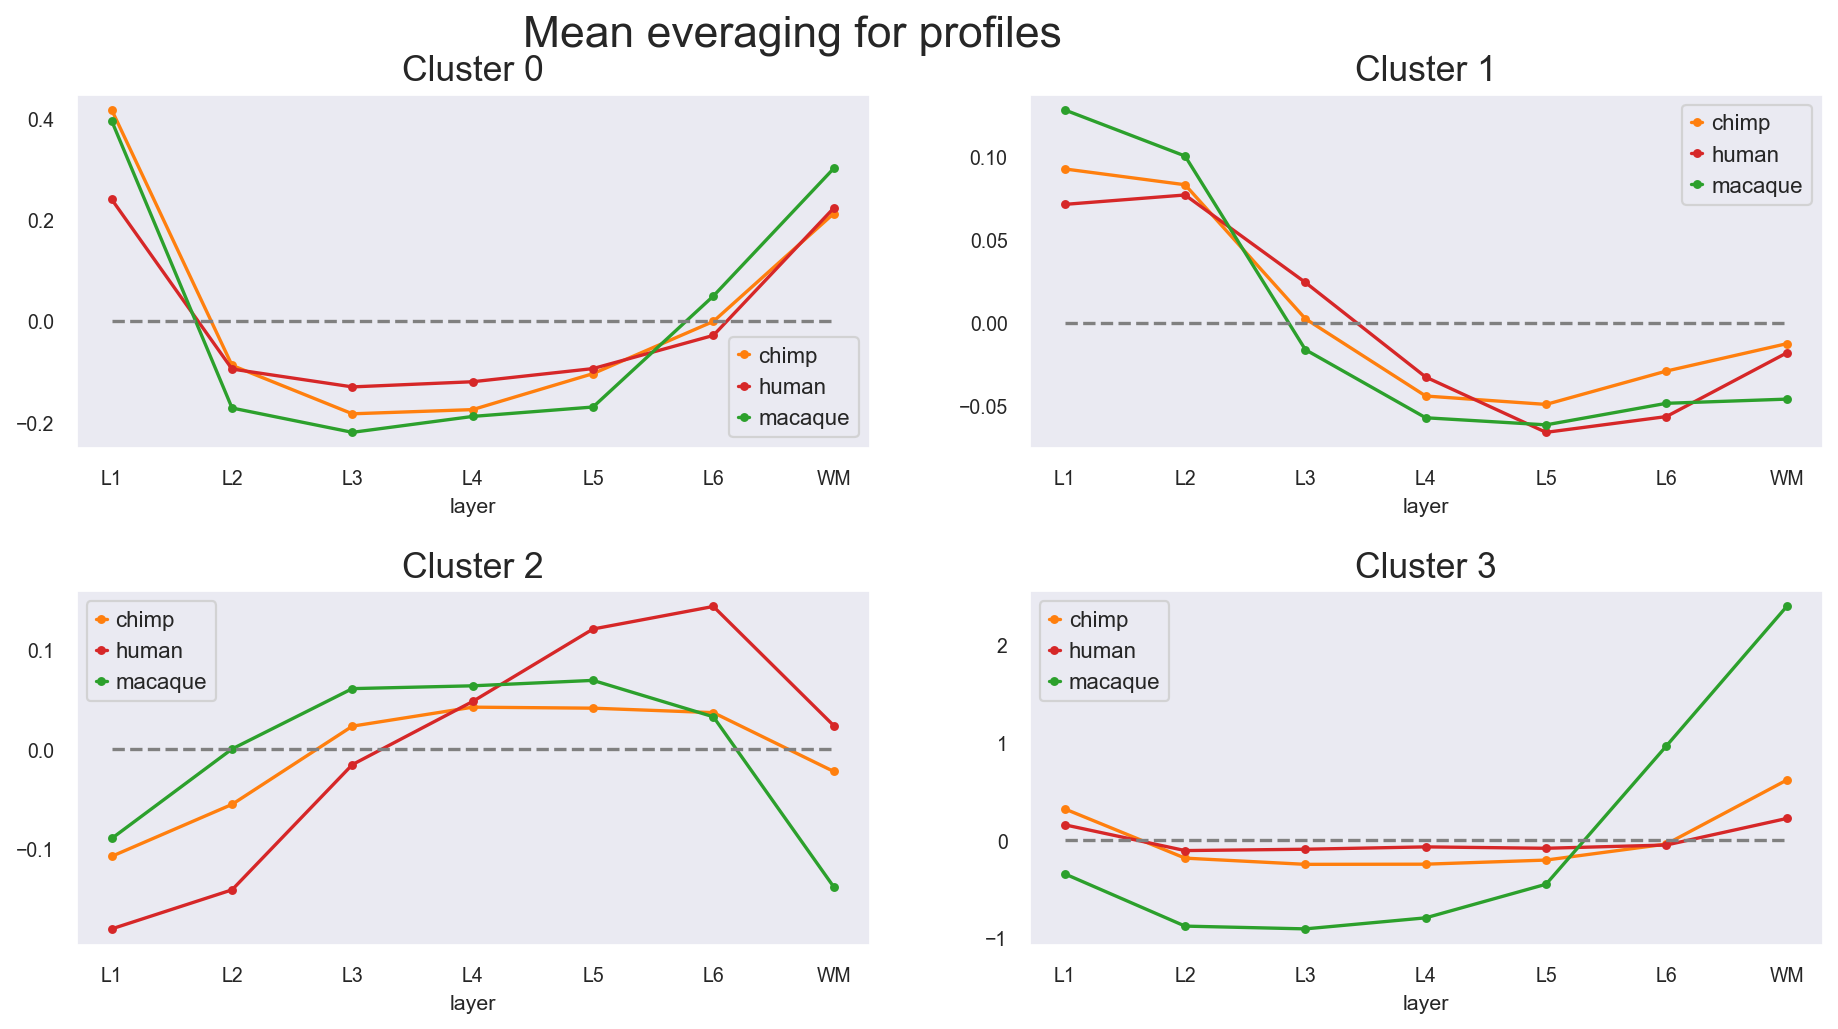

In [28]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

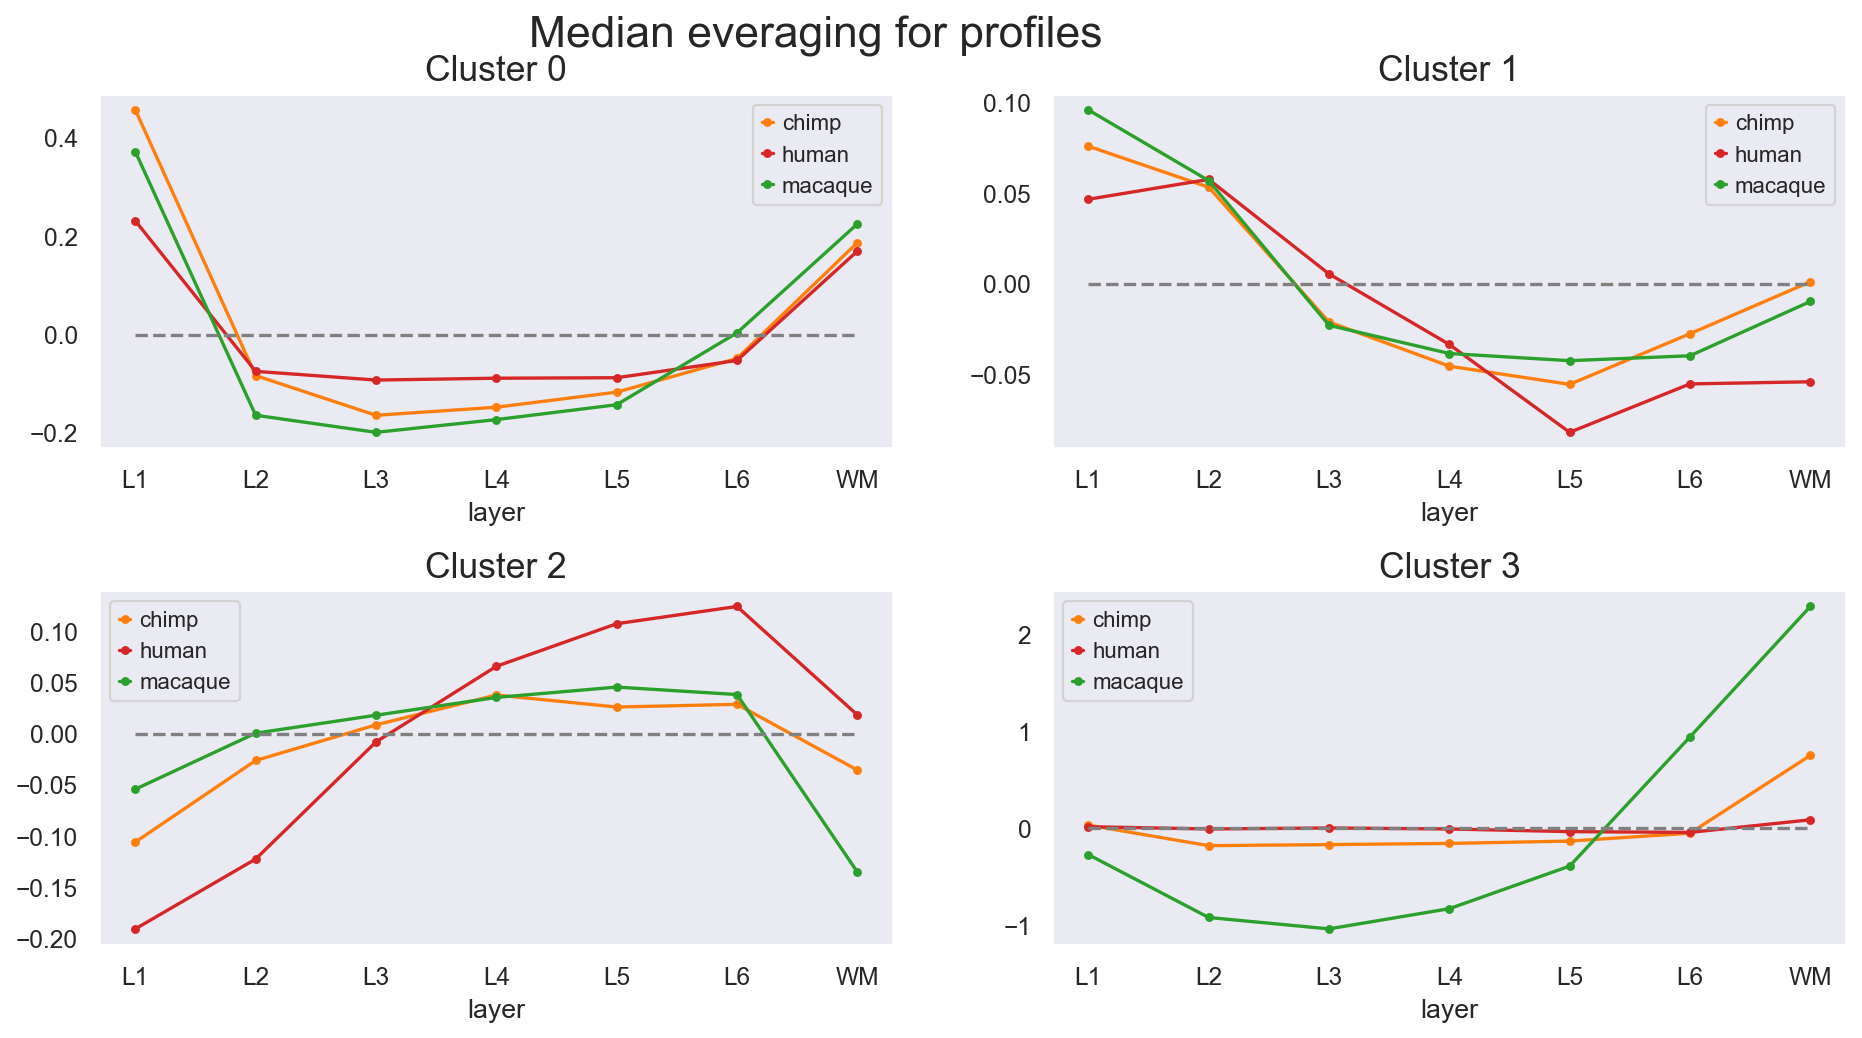

In [29]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# 4 Species

In [30]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_4spe = sc.read_h5ad('results/adata_4spe.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [31]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [32]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

115

In [33]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [34]:
order_4spe = order.intersection(hs_genes_inter)

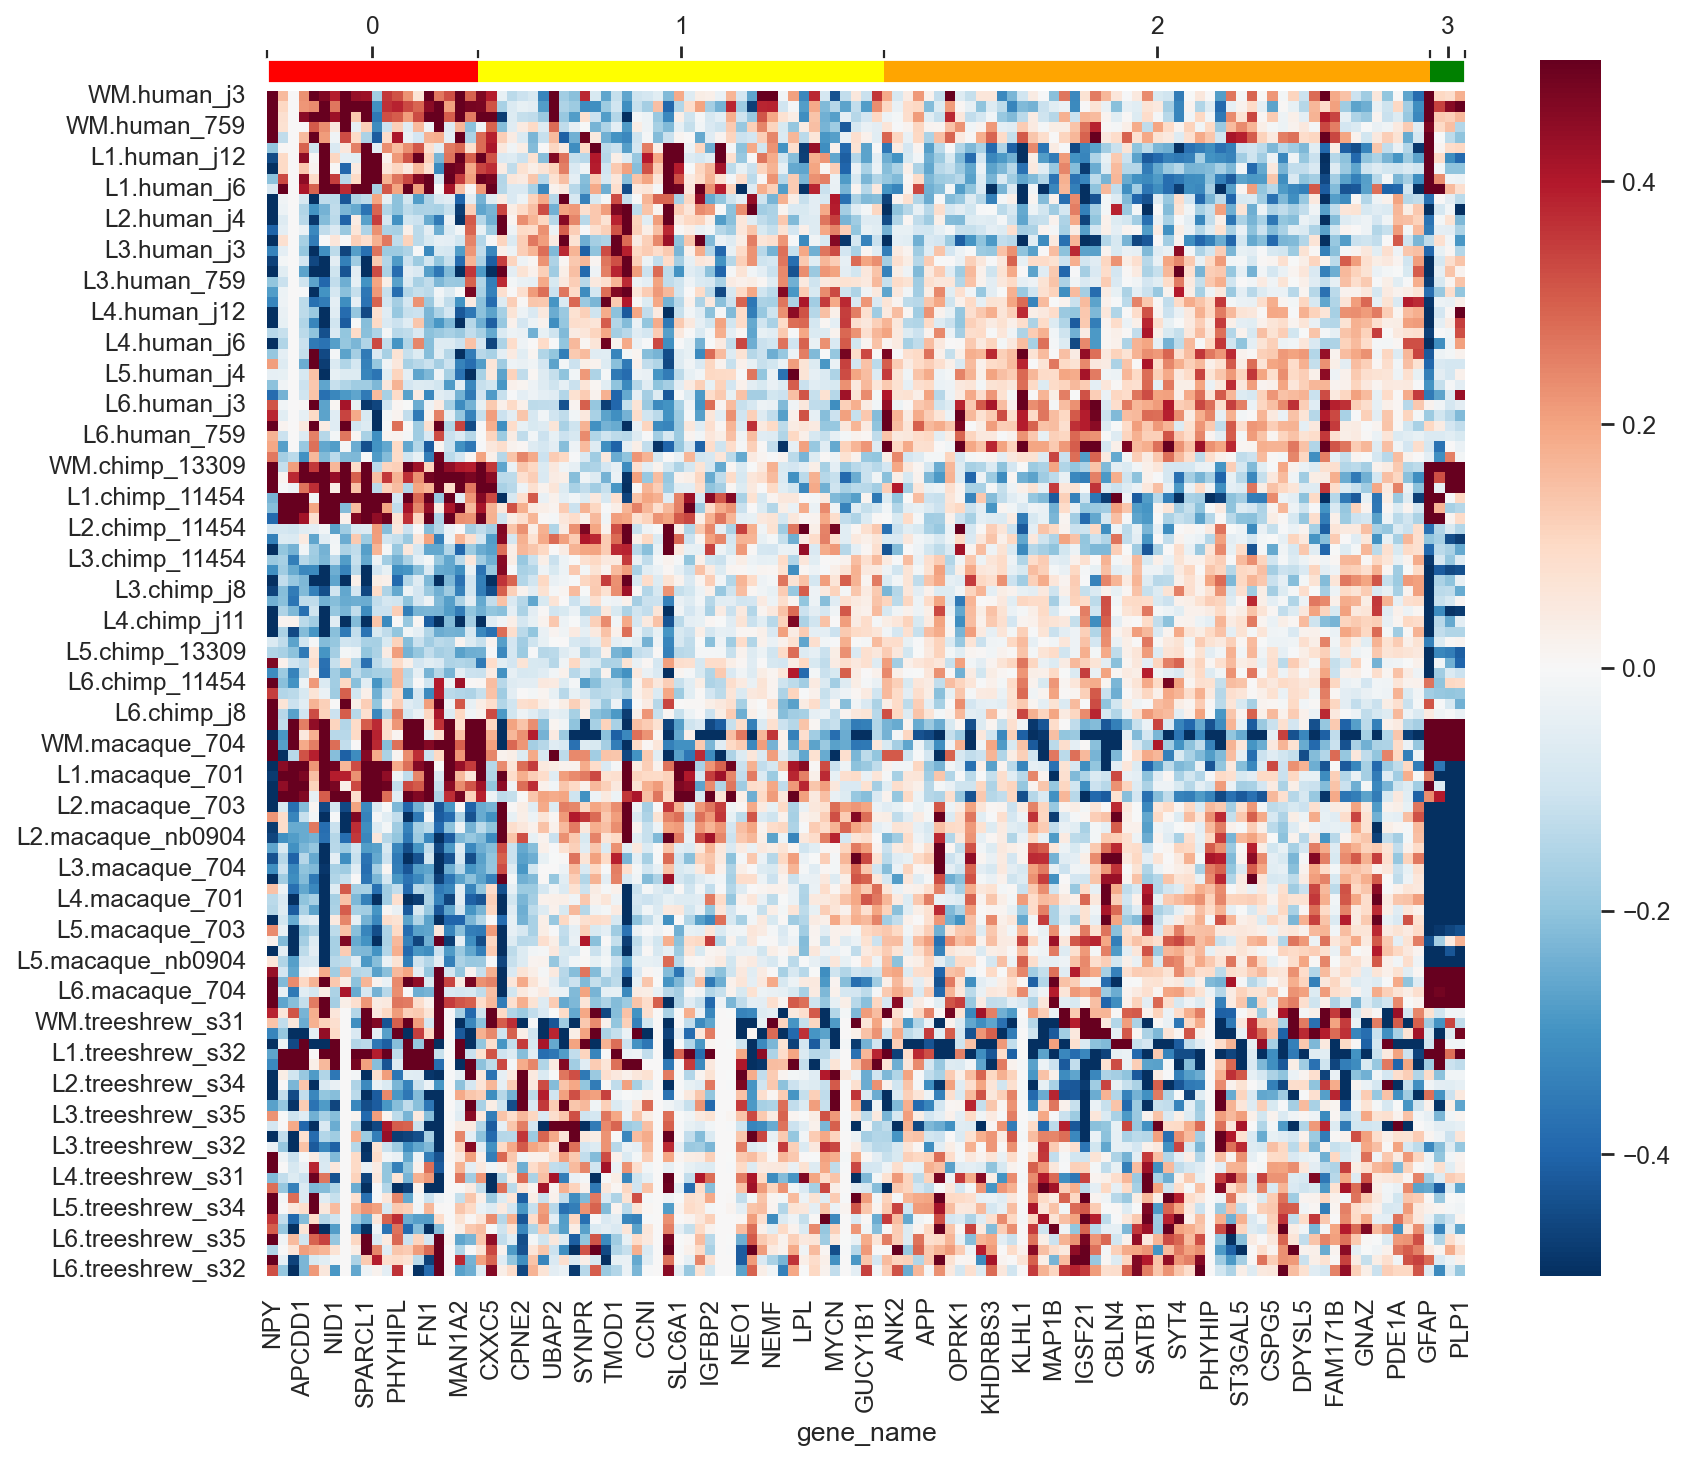

In [35]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [36]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [37]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          IGSF21   CAMK2N1    SLC2A1    MAN1A2   S100A10      RGS4  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.231617 -0.100126  0.549012  0.226507  0.025641 -0.215088   
          L2    -0.164320 -0.045536 -0.105929 -0.075494 -0.004033 -0.280267   
          L3    -0.013440  0.078886 -0.085139 -0.287561 -0.141873  0.079573   
          L4     0.176425  0.037796 -0.159376 -0.323849  0.201904  0.192206   

gene_name          KIF21B     TMCC2      NID1    ZBTB18  ...     KCNG1  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1    -0.061434  0.090244  0.772159 -0.137080  ... -0.163782   
          L2     0.055080  0.029616 -0.101655  0.238887  ...  0.003626   
          L3     0.114423  0.110009 -0.183162  0.185809  ...  0.160608   
          L4     0.066458 -0.001428 -0.167780  0.131912  ...  0.056947   

gene_name            DOK5     CBLN4   TMEM59L      ETFB      GNAZ      TSPO  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.012182  0.309610 -0.141558  0.162136 -0.039300  0.156637   
          L2     0.176226  0.122471 -0.012853 -0.038228  0.123926 -0.074830   
          L3     0.072969  0.016419  0.074497 -0.048922  0.102861 -0.067673   
          L4    -0.025213 -0.012583  0.036490  0.016441  0.079627 -0.098315   

gene_name           NCAM2      JAM2       APP  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.075177  0.285189 -0.117498  
          L2     0.041594 -0.111063 -0.100191  
          L3    -0.014084 -0.064058  0.082678  
          L4    -0.011287 -0.068254  0.083122  

[5 rows x 115 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

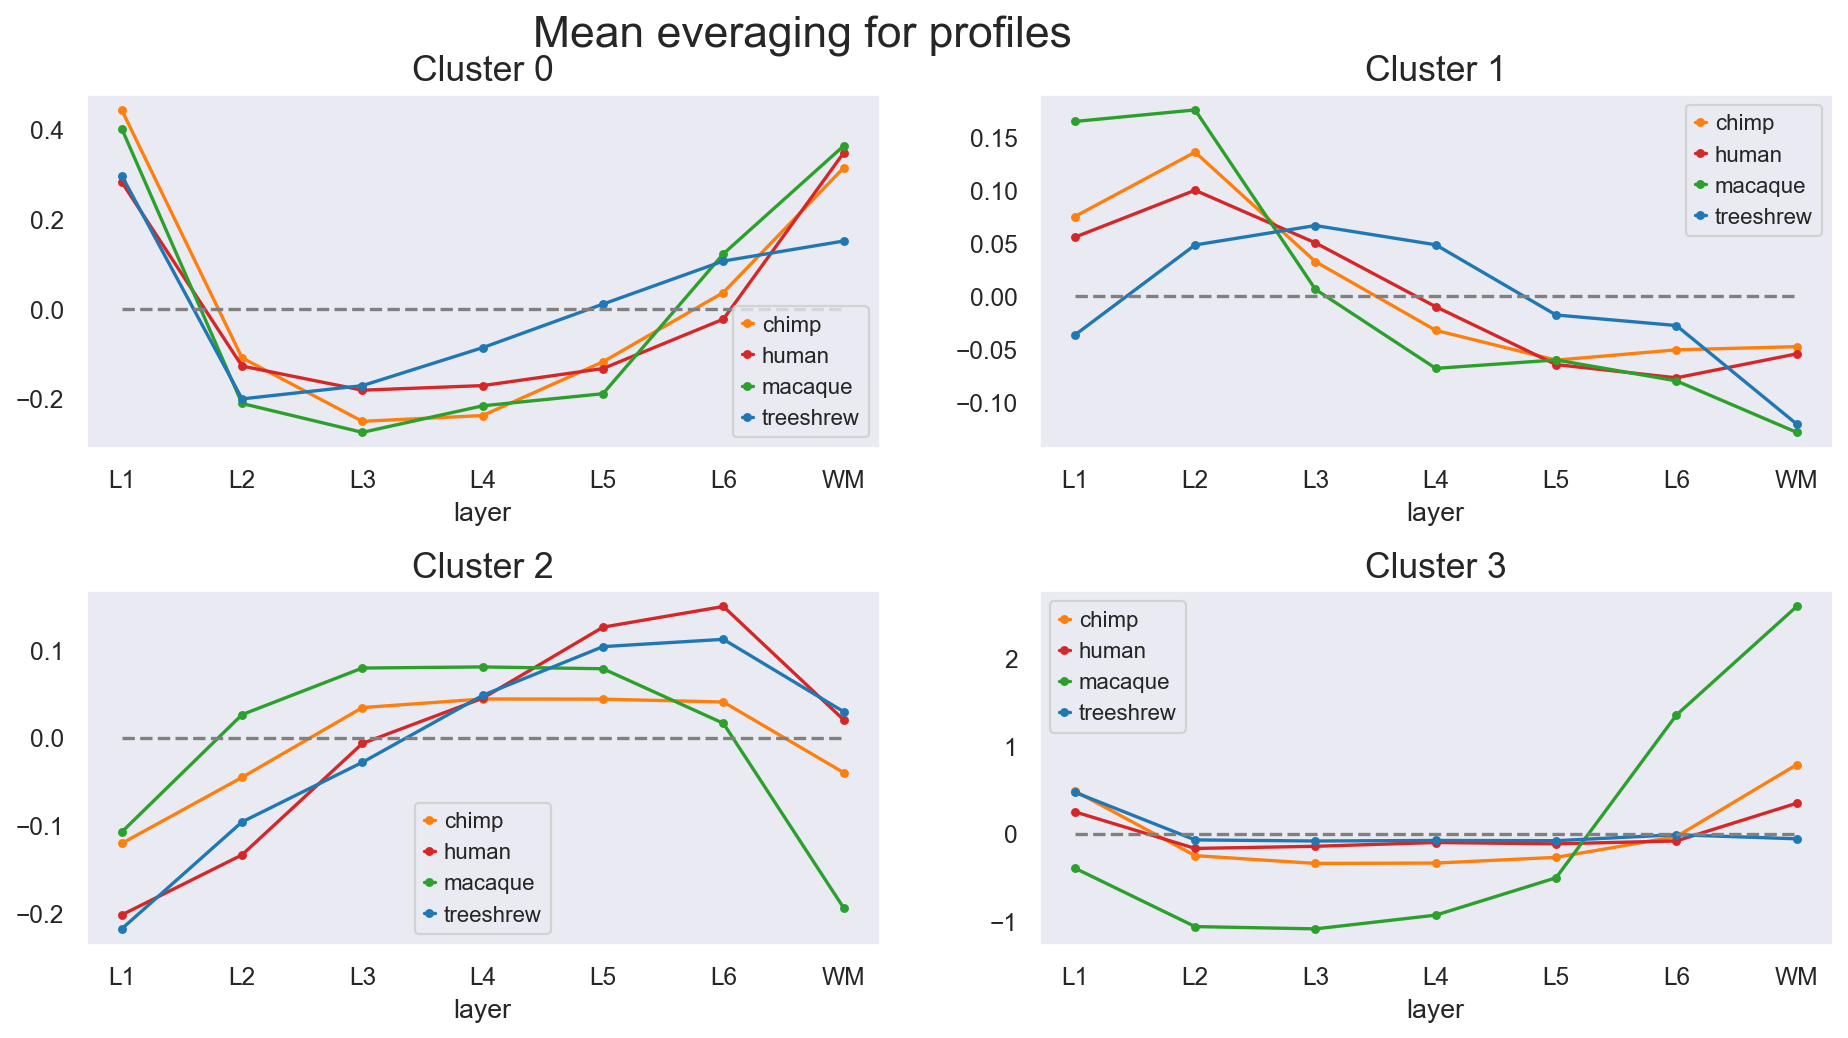

In [38]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

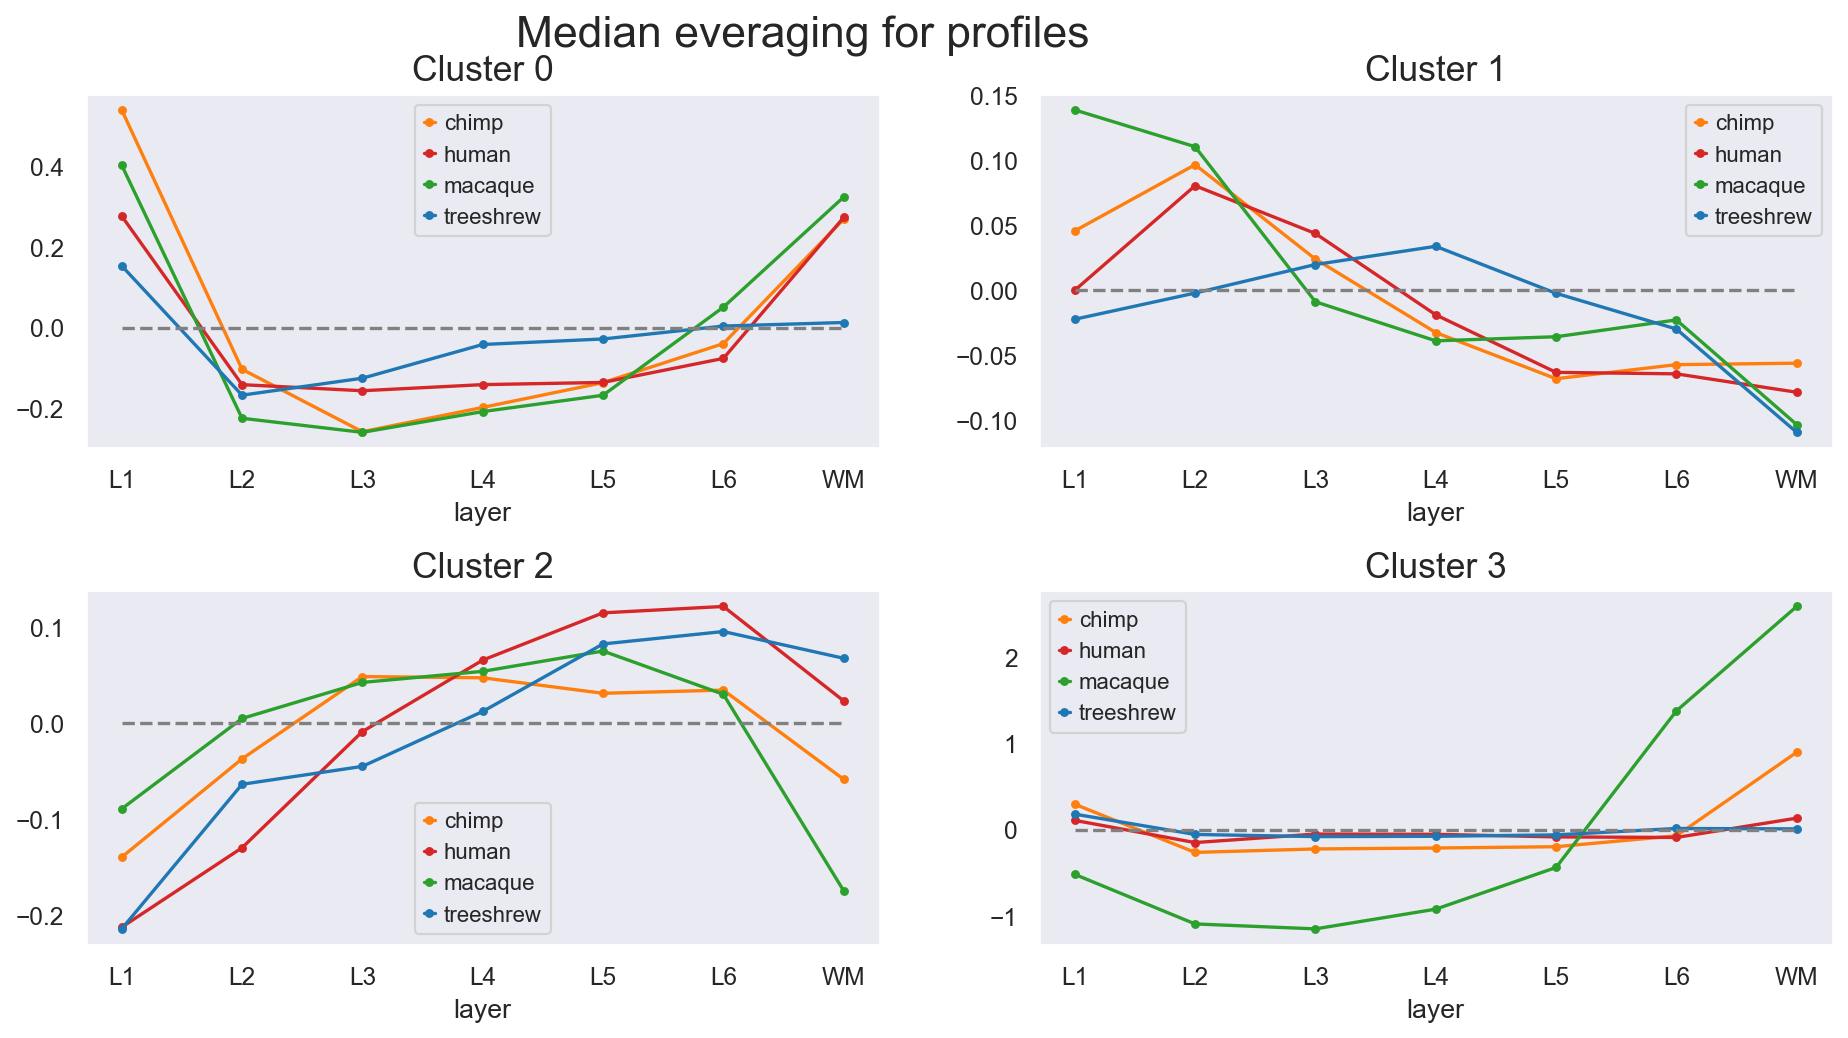

In [39]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# Intersection with ANOVA clusters

In [40]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTA2', 'ADI1', 'AKT3', 'ALCAM', 'ANK2', 'APBB2', 'APCDD1', 'APLP2',
       'APP', 'AQP4',
       ...
       'TSPO', 'TTC3', 'TTYH1', 'TUBA4A', 'UBAP2', 'VAT1L', 'VSTM2A', 'ZBTB18',
       'ZEB2', 'ZMYND8'],
      dtype='object', length=159)

In [41]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1     2    3
ANOVA_labels                       
0              1.0  22.0   1.0  0.0
1              3.0   1.0  10.0  0.0
2              0.0   6.0  40.0  0.0
3              3.0   0.0   0.0  5.0
4              1.0   6.0   1.0  0.0
5              0.0   5.0  19.0  0.0
6             18.0  14.0   3.0  0.0

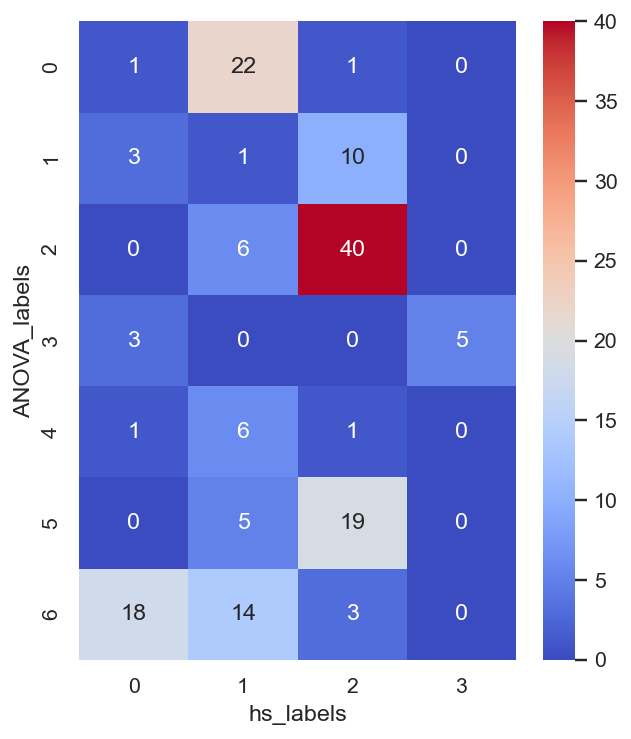

In [42]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

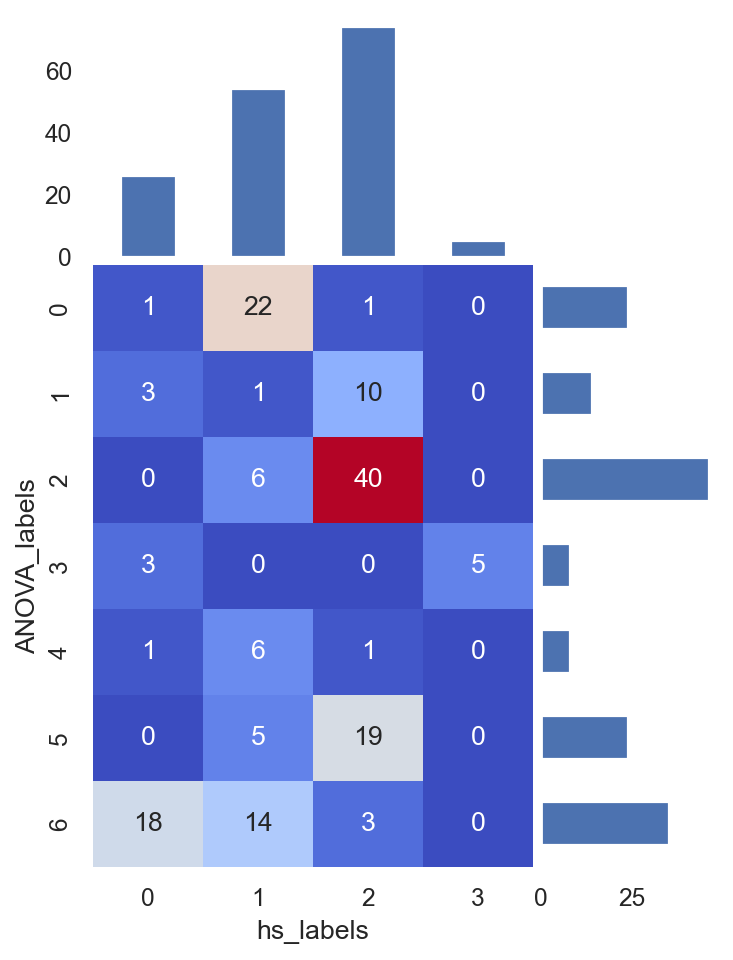

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [44]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/4 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [45]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [46]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
extracellular matrix organization (GO:0030198)         1  0.000001   
external encapsulating structure organization (...     2  0.000003   
extracellular structure organization (GO:0043062)      3  0.000003   
peptide cross-linking (GO:0018149)                     4  0.000061   
positive regulation of cell differentiation (GO...     5  0.000062   

                                                       Z-score  \
Term                                                             
extracellular matrix organization (GO:0030198)       22.245098   
external encapsulating structure organization (...   27.197015   
extracellular structure organization (GO:0043062)    26.794118   
peptide cross-linking (GO:0018149)                  327.714286   
positive regulation of cell differentiation (GO...   14.140625   

                                                    Combined score  \
Term                                                                 
extracellular matrix organization (GO:0030198)          305.837278   
external encapsulating structure organization (...      344.899430   
extracellular structure organization (GO:0043062)       337.949804   
peptide cross-linking (GO:0018149)                     3178.631529   
positive regulation of cell differentiation (GO...      136.963858   

                                                                            Overlapping genes  \
Term                                                                                            
extracellular matrix organization (GO:0030198)      [COL1A1, COL18A1, COL3A1, GSN, FN1, NID1]   
external encapsulating structure organization (...       [COL1A1, COL18A1, COL3A1, FN1, NID1]   
extracellular structure organization (GO:0043062)        [COL1A1, COL18A1, COL3A1, FN1, NID1]   
peptide cross-linking (GO:0018149)                                              [COL3A1, FN1]   
positive regulation of cell differentiation (GO...        [COL1A1, GPRC5B, ID2, IGFBP3, CCN2]   

                                                    Adjusted P-value  \
Term                                                                   
extracellular matrix organization (GO:0030198)              0.000367   
external encapsulating structure organization (...          0.000381   
extracellular structure organization (GO:0043062)           0.000381   
peptide cross-linking (GO:0018149)                          0.004264   
positive regulation of cell differentiation (GO...          0.004264   

                                                    Old p-value  \
Term                                                              
extracellular matrix organization (GO:0030198)                0   
external encapsulating structure organization (...            0   
extracellular structure organization (GO:0043062)             0   
peptide cross-linking (GO:0018149)                            0   
positive regulation of cell differentiation (GO...            0   

                                                    Old adjusted p-value  \
Term                                                                       
extracellular matrix organization (GO:0030198)                         0   
external encapsulating structure organization (...                     0   
extracellular structure organization (GO:0043062)                      0   
peptide cross-linking (GO:0018149)                                     0   
positive regulation of cell differentiation (GO...                     0   

                                                    num_overlap_genes  \
Term                                                                    
extracellular matrix organization (GO:0030198)                      6   
external encapsulating structure organization (...                  5   
extracellular structure organization (GO:0043062)                   5   
peptide cross-linking (GO:0018149)                    

In [47]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 15)].index.unique()
terms.size

39

In [48]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

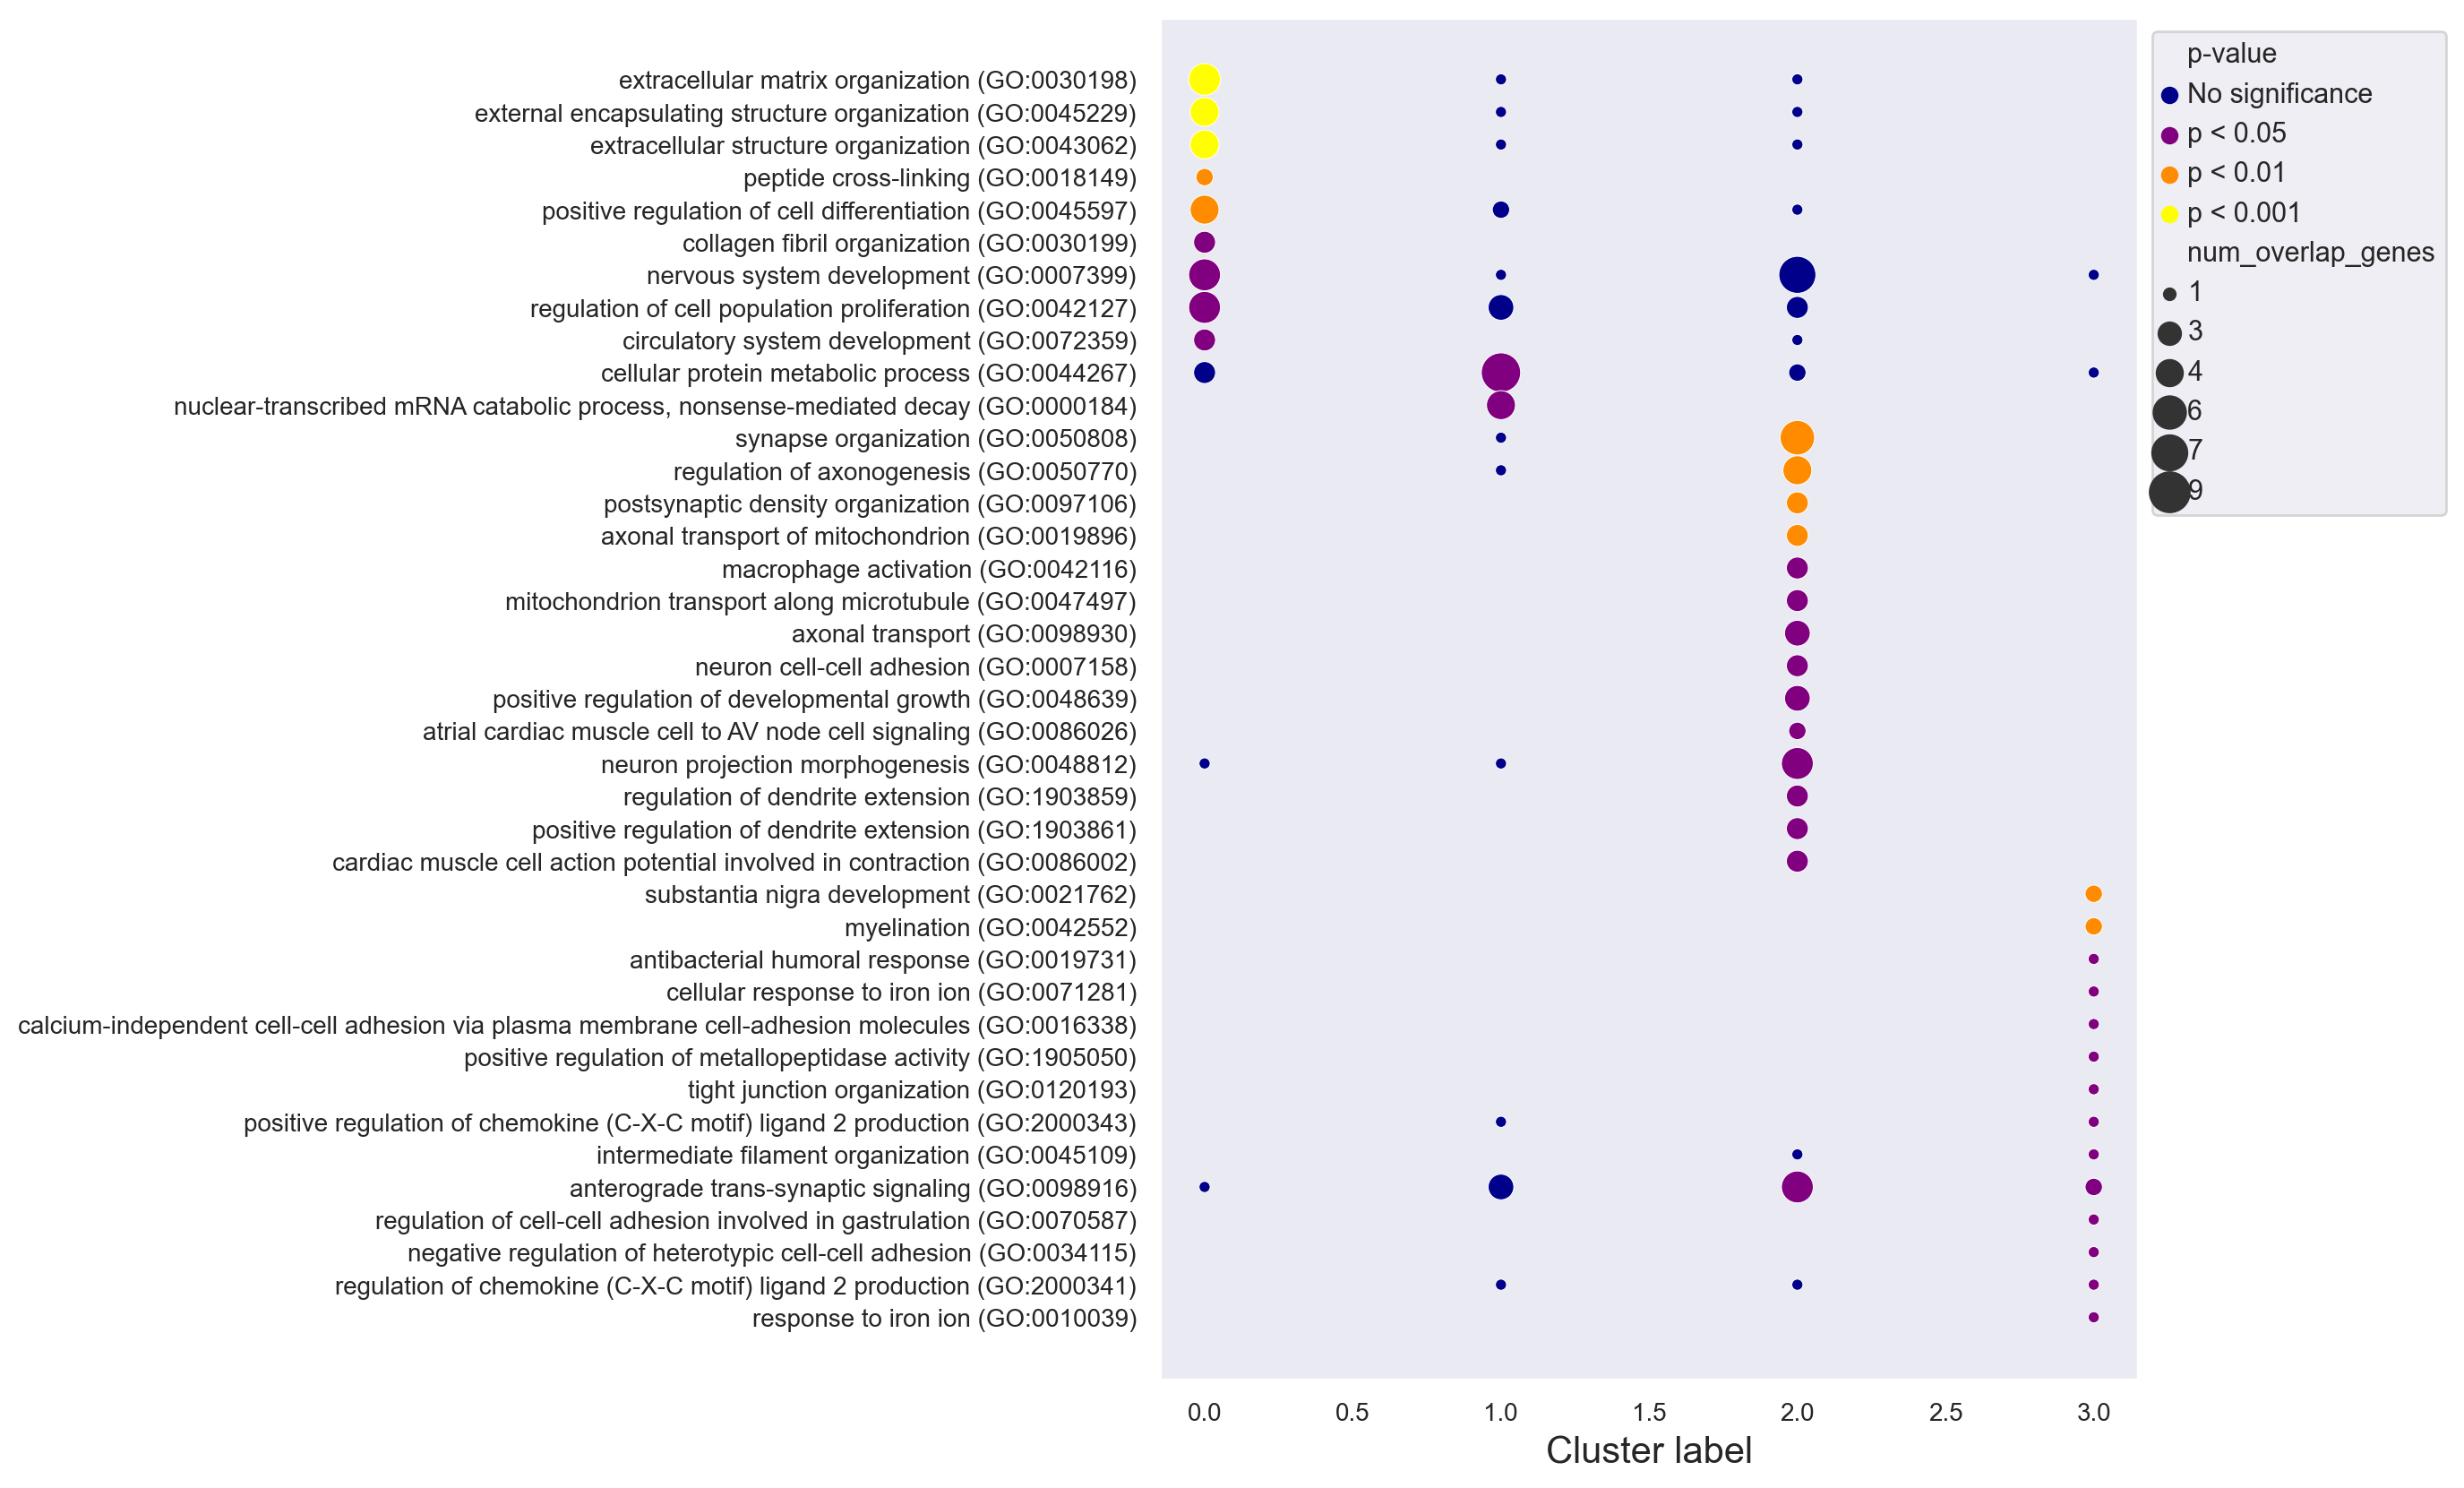

In [49]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [50]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [51]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Myeloid Dendritic Type 1 CL0000782                     1  0.000061   
Oligodendrocyte 1 CL0000128                            2  0.000102   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128     3  0.000102   
Smooth Muscle CL0000192                                4  0.000153   
Activated Stellate CL0002410                           5  0.000213   

                                                       Z-score  \
Term                                                             
Myeloid Dendritic Type 1 CL0000782                  327.714286   
Oligodendrocyte 1 CL0000128                         218.452381   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128  218.452381   
Smooth Muscle CL0000192                             163.821429   
Activated Stellate CL0002410                        131.042857   

                                                    Combined score  \
Term                                                                 
Myeloid Dendritic Type 1 CL0000782                     3178.631529   
Oligodendrocyte 1 CL0000128                            2007.707930   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128     2007.707930   
Smooth Muscle CL0000192                                1439.524738   
Activated Stellate CL0002410                           1107.667418   

                                                   Overlapping genes  \
Term                                                                   
Myeloid Dendritic Type 1 CL0000782                        [GSN, ID2]   
Oligodendrocyte 1 CL0000128                         [COL18A1, S100B]   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128  [COL18A1, S100B]   
Smooth Muscle CL0000192                               [ACTA2, CSRP1]   
Activated Stellate CL0002410                        [COL1A1, COL3A1]   

                                                    Adjusted P-value  \
Term                                                                   
Myeloid Dendritic Type 1 CL0000782                          0.000701   
Oligodendrocyte 1 CL0000128                                 0.000701   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128          0.000701   
Smooth Muscle CL0000192                                     0.000701   
Activated Stellate CL0002410                                0.000701   

                                                    Old p-value  \
Term                                                              
Myeloid Dendritic Type 1 CL0000782                            0   
Oligodendrocyte 1 CL0000128                                   0   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128            0   
Smooth Muscle CL0000192                                       0   
Activated Stellate CL0002410                                  0   

                                                    Old adjusted p-value  \
Term                                                                       
Myeloid Dendritic Type 1 CL0000782                                     0   
Oligodendrocyte 1 CL0000128                                            0   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128                     0   
Smooth Muscle CL0000192                                                0   
Activated Stellate CL0002410                                           0   

                                                    num_overlap_genes  \
Term                                                                    
Myeloid Dendritic Type 1 CL0000782                                  2   
Oligodendrocyte 1 CL0000128                                         2   
OPALIN+ ENPP6+ Layer 3-6 Oligodendrocyte CL0000128                  2   
Smooth Muscle CL0000192                                             2   
Activated Stellate CL0002410                                        2   

                                                    neg_log10(p_adj)  \
Term      

In [52]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

35

In [53]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

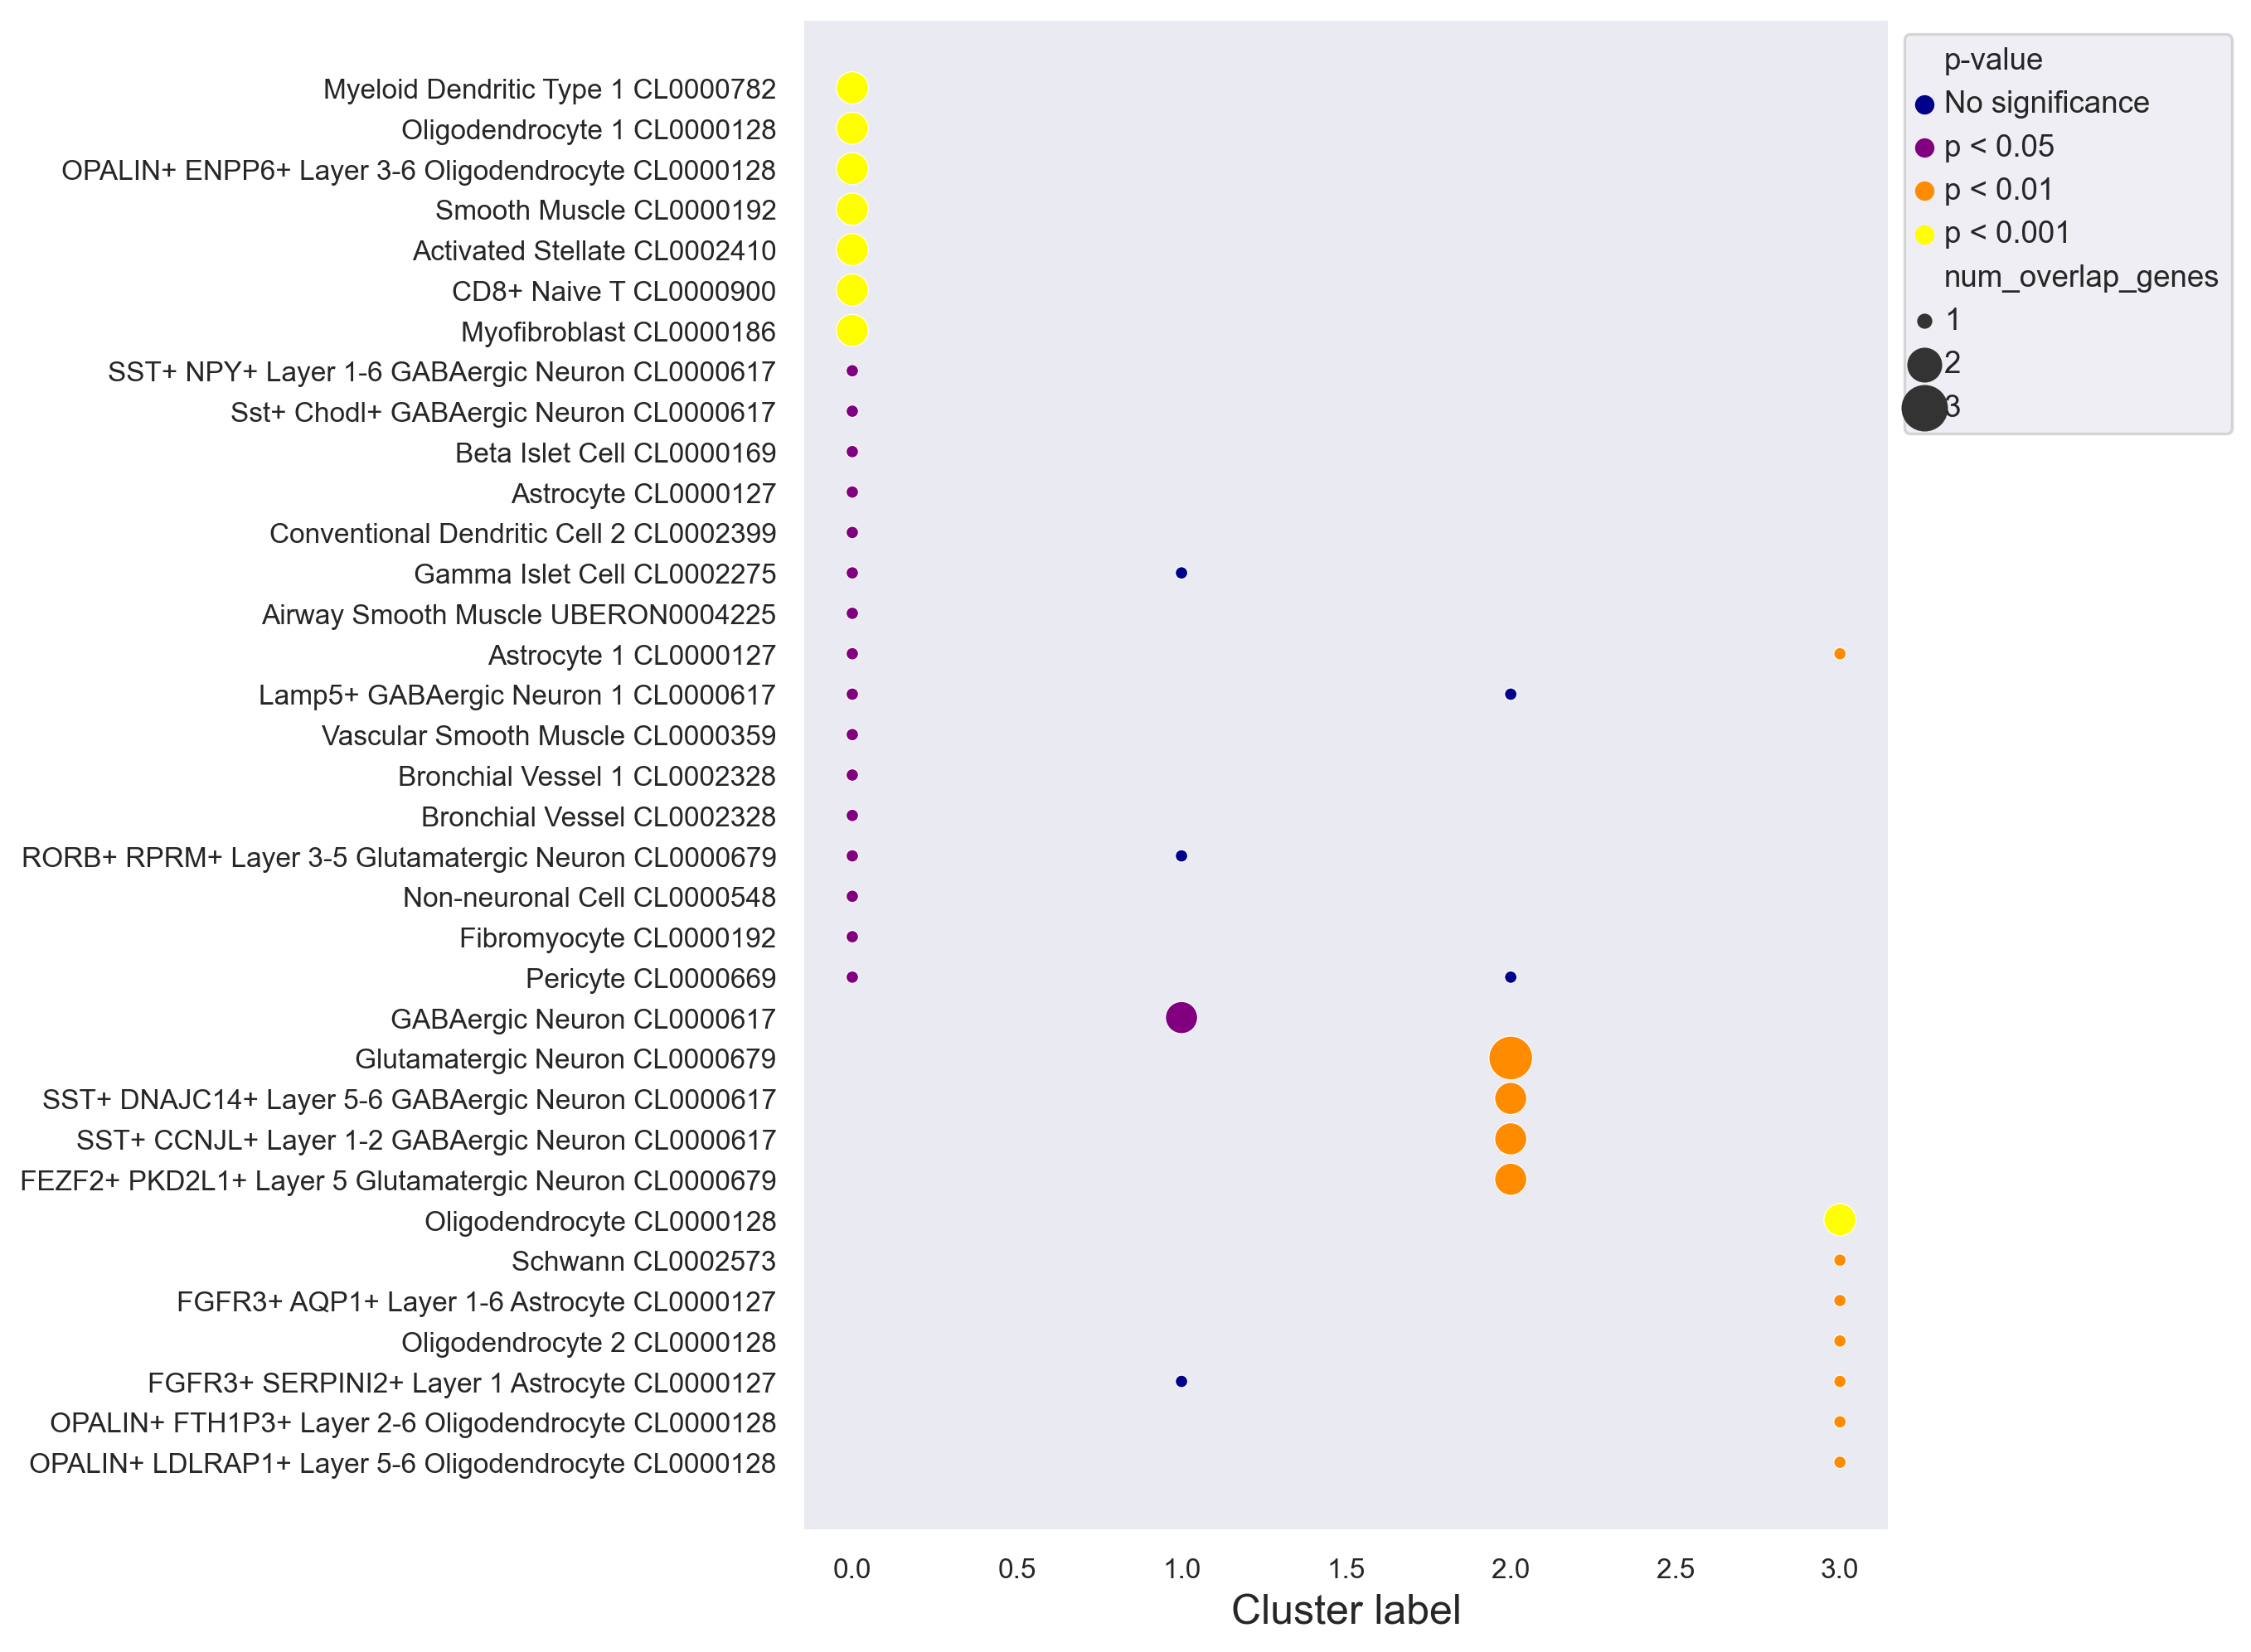

In [54]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [55]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [56]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank         p-val  \
Term                                                                     
abnormal aorta elastic tissue morphology MP:000...     1  6.200708e-07   
sporadic seizures MP:0000951                           2  3.427312e-05   
aortic dissection MP:0004044                           3  1.019939e-04   
thick dermal layer MP:0001245                          4  1.526813e-04   
abnormal glial cell physiology MP:0003690              5  1.526813e-04   

                                                       Z-score  \
Term                                                             
abnormal aorta elastic tissue morphology MP:000...  339.814815   
sporadic seizures MP:0000951                         59.875817   
aortic dissection MP:0004044                        218.452381   
thick dermal layer MP:0001245                       163.821429   
abnormal glial cell physiology MP:0003690           163.821429   

                                                    Combined score  \
Term                                                                 
abnormal aorta elastic tissue morphology MP:000...     4857.120030   
sporadic seizures MP:0000951                            615.592201   
aortic dissection MP:0004044                           2007.707930   
thick dermal layer MP:0001245                          1439.524738   
abnormal glial cell physiology MP:0003690              1439.524738   

                                                          Overlapping genes  \
Term                                                                          
abnormal aorta elastic tissue morphology MP:000...  [ACTA2, COL1A1, COL3A1]   
sporadic seizures MP:0000951                            [NPY, SLC2A1, NID1]   
aortic dissection MP:0004044                               [COL1A1, COL3A1]   
thick dermal layer MP:0001245                              [COL1A1, COL3A1]   
abnormal glial cell physiology MP:0003690                   [HEPACAM, AQP4]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal aorta elastic tissue morphology MP:000...          0.000301   
sporadic seizures MP:0000951                                0.008328   
aortic dissection MP:0004044                                0.012959   
thick dermal layer MP:0001245                               0.012959   
abnormal glial cell physiology MP:0003690                   0.012959   

                                                    Old p-value  \
Term                                                              
abnormal aorta elastic tissue morphology MP:000...            0   
sporadic seizures MP:0000951                                  0   
aortic dissection MP:0004044                                  0   
thick dermal layer MP:0001245                                 0   
abnormal glial cell physiology MP:0003690                     0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal aorta elastic tissue morphology MP:000...                     0   
sporadic seizures MP:0000951                                           0   
aortic dissection MP:0004044                                           0   
thick dermal layer MP:0001245                                          0   
abnormal glial cell physiology MP:0003690                              0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal aorta elastic tissue morphology MP:000...                  3   
sporadic seizures MP:0000951                                        3   
aortic dissection MP:0004044                                        2   
thick dermal layer MP:0001245                                       2   
abnormal glial cell physiology MP:0003690                           2   

     

In [57]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

158

In [58]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

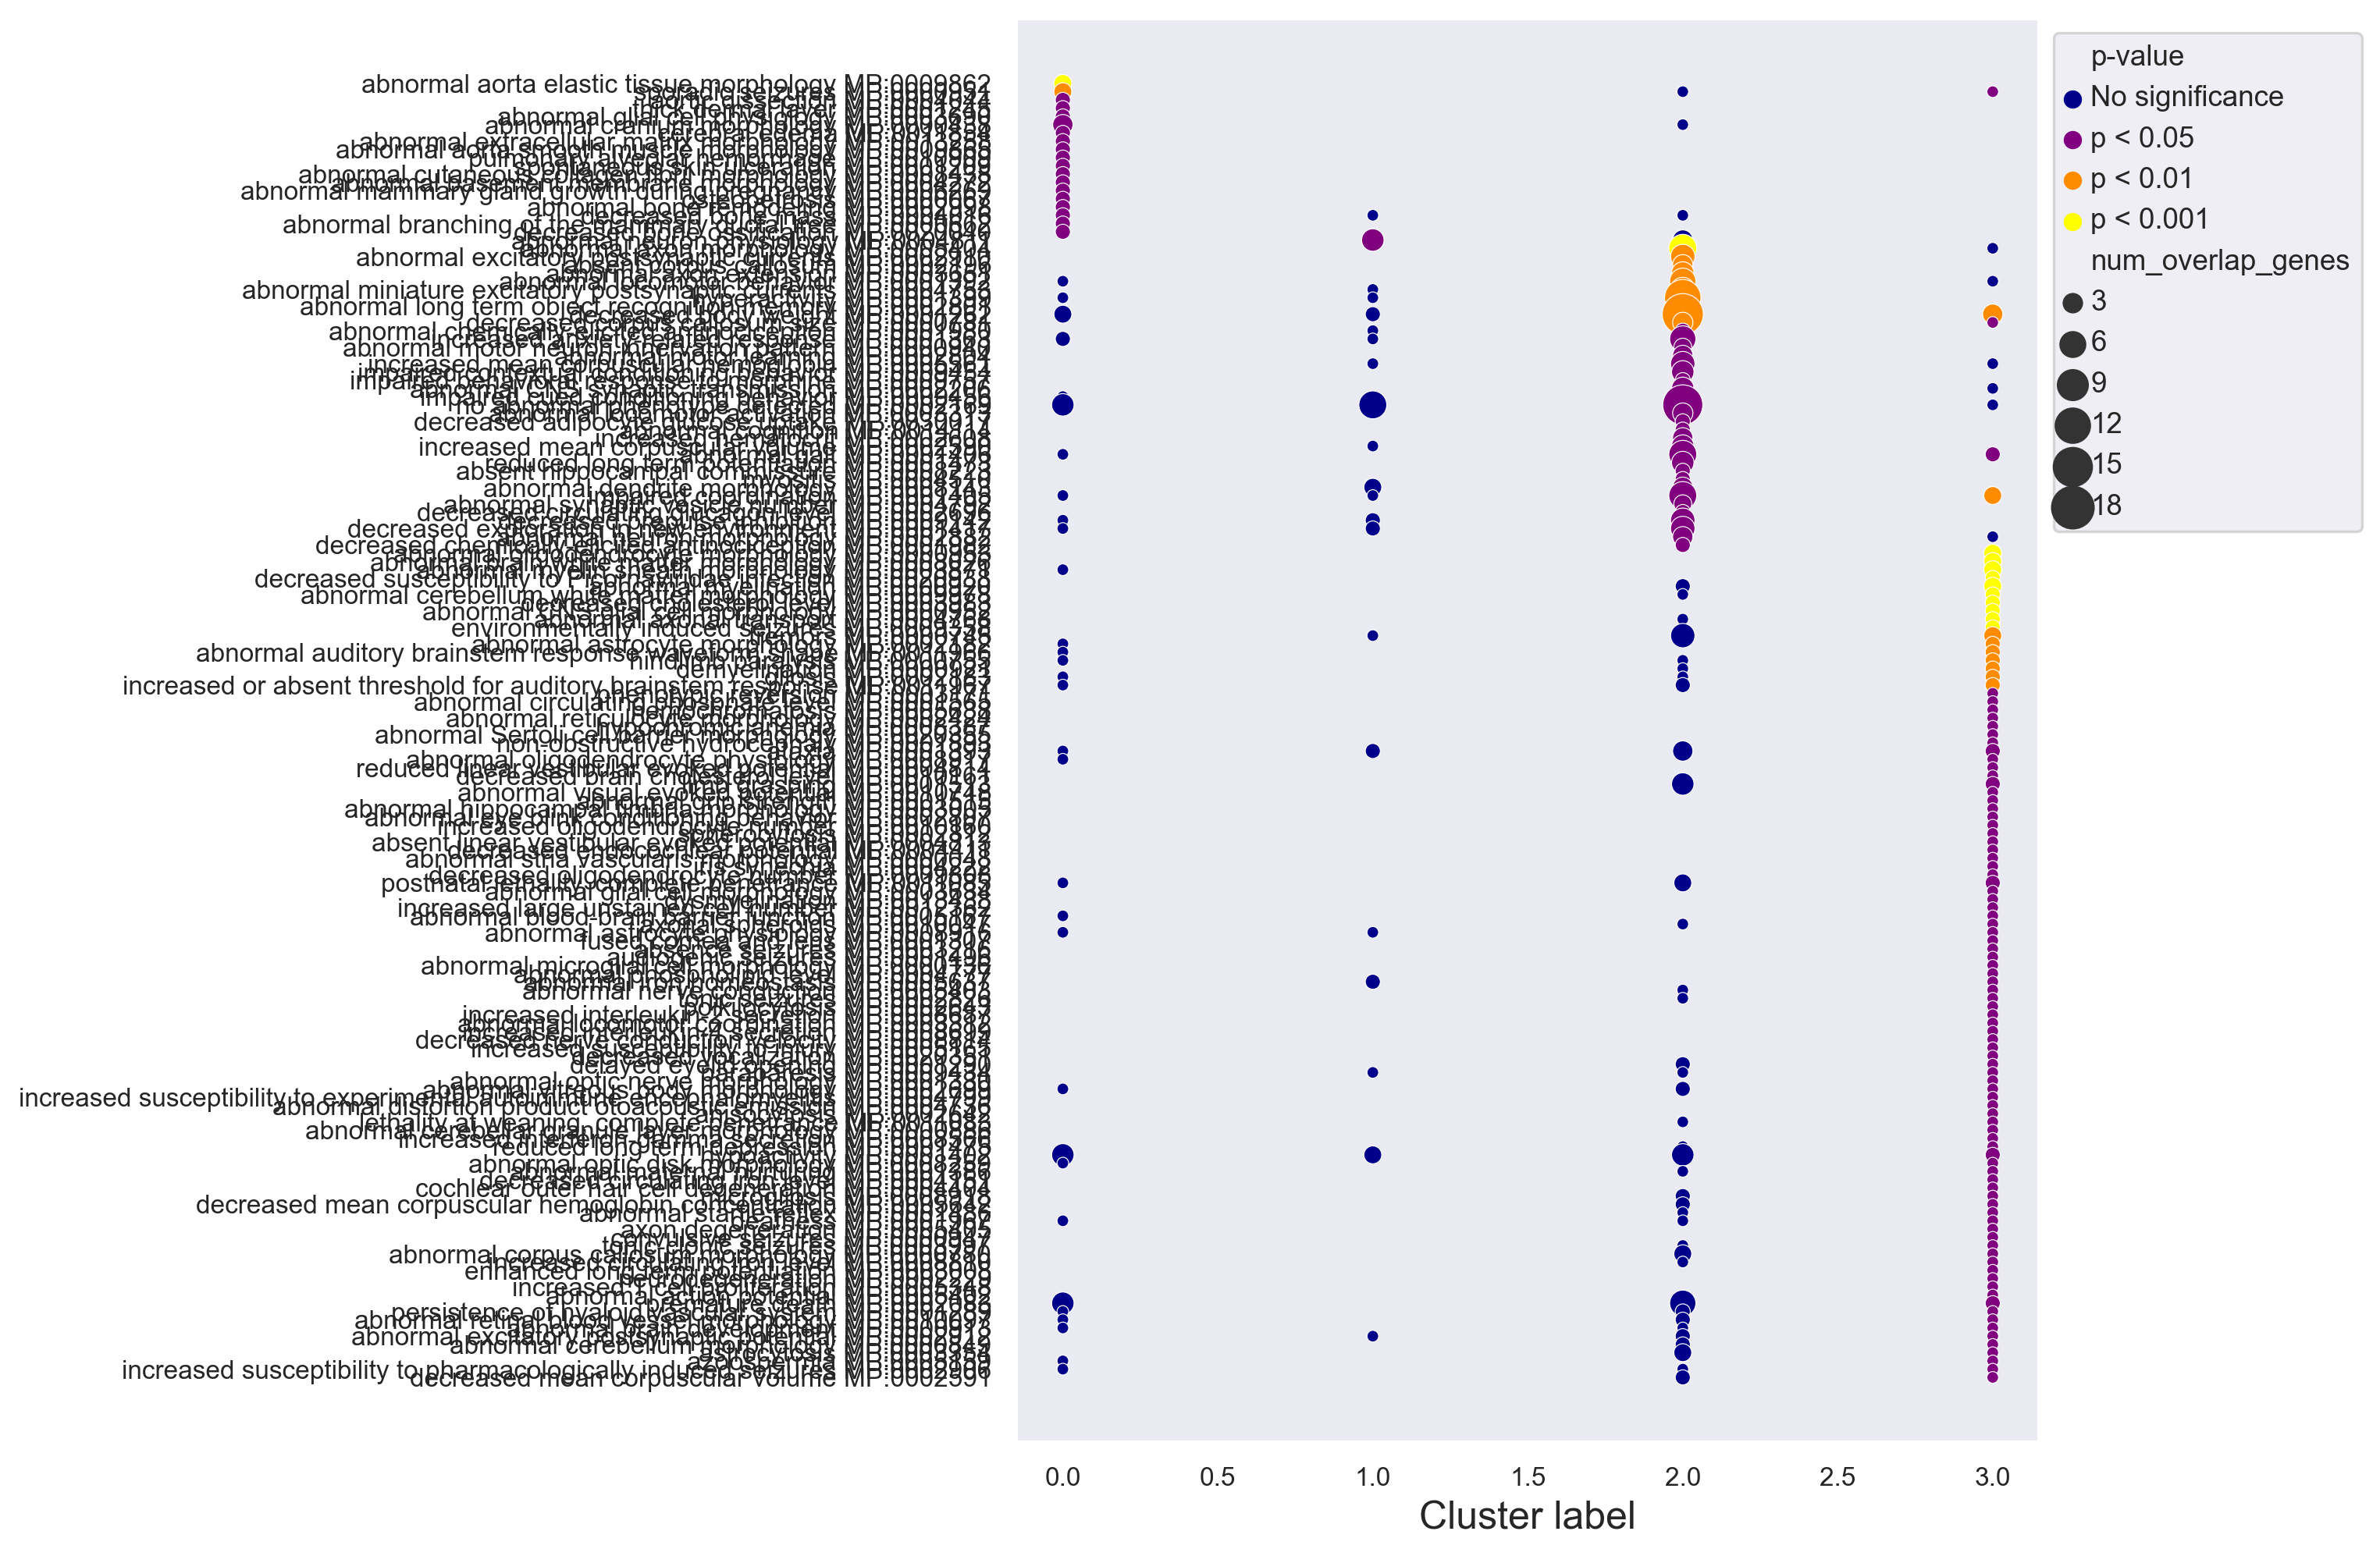

In [59]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [60]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [61]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Collagen Chain Trimerization R-HSA-8948216             1  0.000005   
Assembly Of Collagen Fibrils And Other Multimer...     2  0.000034   
Extracellular Matrix Organization R-HSA-1474244        3  0.000040   
Collagen Biosynthesis And Modifying Enzymes R-H...     4  0.000060   
Collagen Formation R-HSA-1474290                       5  0.000174   

                                                       Z-score  \
Term                                                             
Collagen Chain Trimerization R-HSA-8948216          127.361111   
Assembly Of Collagen Fibrils And Other Multimer...   59.875817   
Extracellular Matrix Organization R-HSA-1474244      15.624138   
Collagen Biosynthesis And Modifying Enzymes R-H...   48.449735   
Collagen Formation R-HSA-1474290                     32.784946   

                                                    Combined score  \
Term                                                                 
Collagen Chain Trimerization R-HSA-8948216             1553.066990   
Assembly Of Collagen Fibrils And Other Multimer...      615.592201   
Extracellular Matrix Organization R-HSA-1474244         158.413082   
Collagen Biosynthesis And Modifying Enzymes R-H...      470.732570   
Collagen Formation R-HSA-1474290                        283.716383   

                                                                       Overlapping genes  \
Term                                                                                       
Collagen Chain Trimerization R-HSA-8948216                     [COL1A1, COL18A1, COL3A1]   
Assembly Of Collagen Fibrils And Other Multimer...             [COL1A1, COL18A1, COL3A1]   
Extracellular Matrix Organization R-HSA-1474244     [COL1A1, COL18A1, COL3A1, FN1, NID1]   
Collagen Biosynthesis And Modifying Enzymes R-H...             [COL1A1, COL18A1, COL3A1]   
Collagen Formation R-HSA-1474290                               [COL1A1, COL18A1, COL3A1]   

                                                    Adjusted P-value  \
Term                                                                   
Collagen Chain Trimerization R-HSA-8948216                  0.000739   
Assembly Of Collagen Fibrils And Other Multimer...          0.001923   
Extracellular Matrix Organization R-HSA-1474244             0.001923   
Collagen Biosynthesis And Modifying Enzymes R-H...          0.002202   
Collagen Formation R-HSA-1474290                            0.005094   

                                                    Old p-value  \
Term                                                              
Collagen Chain Trimerization R-HSA-8948216                    0   
Assembly Of Collagen Fibrils And Other Multimer...            0   
Extracellular Matrix Organization R-HSA-1474244               0   
Collagen Biosynthesis And Modifying Enzymes R-H...            0   
Collagen Formation R-HSA-1474290                              0   

                                                    Old adjusted p-value  \
Term                                                                       
Collagen Chain Trimerization R-HSA-8948216                             0   
Assembly Of Collagen Fibrils And Other Multimer...                     0   
Extracellular Matrix Organization R-HSA-1474244                        0   
Collagen Biosynthesis And Modifying Enzymes R-H...                     0   
Collagen Formation R-HSA-1474290                                       0   

                                                    num_overlap_genes  \
Term                                                                    
Collagen Chain Trimerization R-HSA-8948216                          3   
Assembly Of Collagen Fibrils And Other Multimer...                  3   
Extracellular Matrix Organization R-HSA-1474244                     5   
Collagen Biosynthesis And Modifying Enzymes R-H...                  3   
Collagen Formati

In [62]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

37

In [63]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

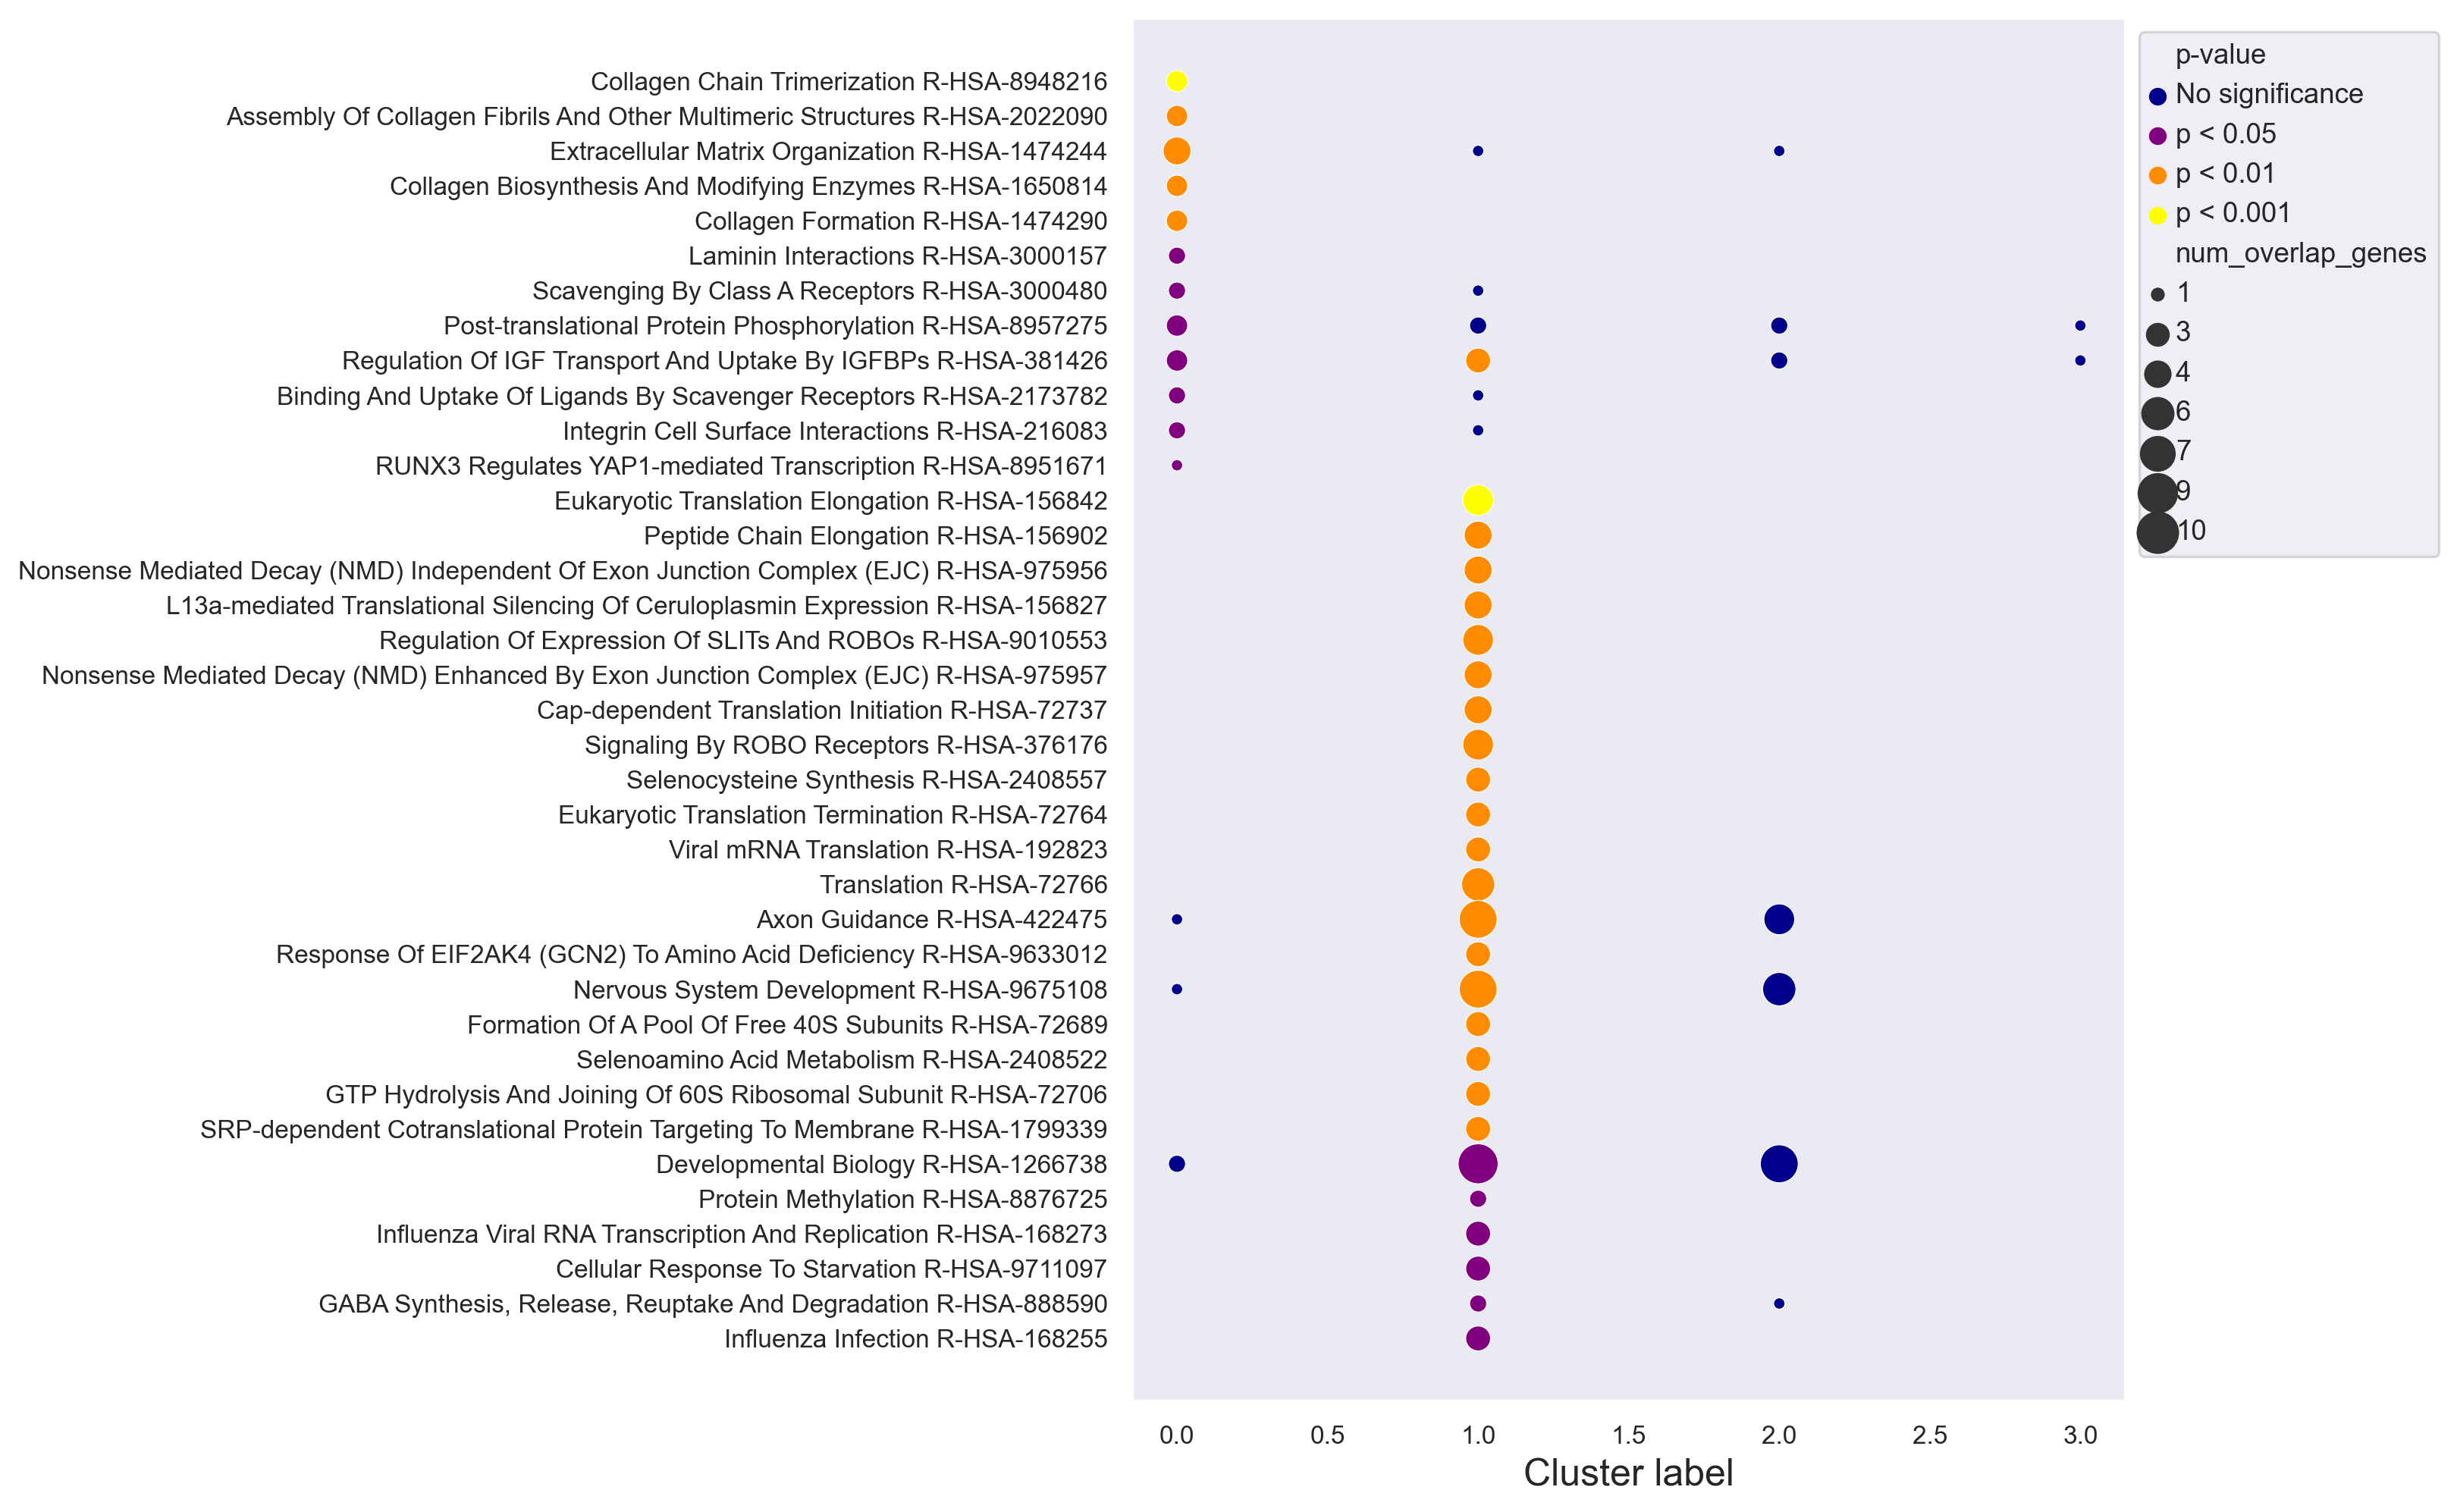

In [64]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [65]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [66]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Protein digestion and absorption                       1  0.000097  40.680000   
Amoebiasis                                             2  0.000404  24.169312   
AGE-RAGE signaling pathway in diabetic complica...     3  0.001086  16.885185   
Relaxin signaling pathway                              4  0.002575  12.325203   
Bile secretion                                         5  0.004218  23.341837   

                                                    Combined score  \
Term                                                                 
Protein digestion and absorption                        376.010978   
Amoebiasis                                              188.872973   
AGE-RAGE signaling pathway in diabetic complica...      115.241314   
Relaxin signaling pathway                                73.483546   
Bile secretion                                          127.643004   

                                                            Overlapping genes  \
Term                                                                            
Protein digestion and absorption                    [COL1A1, COL18A1, COL3A1]   
Amoebiasis                                              [COL1A1, COL3A1, FN1]   
AGE-RAGE signaling pathway in diabetic complica...      [COL1A1, COL3A1, FN1]   
Relaxin signaling pathway                             [ACTA2, COL1A1, COL3A1]   
Bile secretion                                                 [SLC2A1, AQP4]   

                                                    Adjusted P-value  \
Term                                                                   
Protein digestion and absorption                            0.005032   
Amoebiasis                                                  0.010499   
AGE-RAGE signaling pathway in diabetic complica...          0.018829   
Relaxin signaling pathway                                   0.033470   
Bile secretion                                              0.041513   

                                                    Old p-value  \
Term                                                              
Protein digestion and absorption                              0   
Amoebiasis                                                    0   
AGE-RAGE signaling pathway in diabetic complica...            0   
Relaxin signaling pathway                                     0   
Bile secretion                                                0   

                                                    Old adjusted p-value  \
Term                                                                       
Protein digestion and absorption                                       0   
Amoebiasis                                                             0   
AGE-RAGE signaling pathway in diabetic complica...                     0   
Relaxin signaling pathway                                              0   
Bile secretion                                                         0   

                                                    num_overlap_genes  \
Term                                                                    
Protein digestion and absorption                                    3   
Amoebiasis                                                          3   
AGE-RAGE signaling pathway in diabetic complica...                  3   
Relaxin signaling pathway                                           3   
Bile secretion                                                      2   

                                                    neg_log10(p_adj)  \
Term                                                                   
Protein digestion and absorption                            2.298242   
Amoebiasis                                                  1.978855   
AGE-RAGE signaling pathway in diabetic complica...          1.725176   
Relaxin signaling pathway                    

In [67]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

8

In [68]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

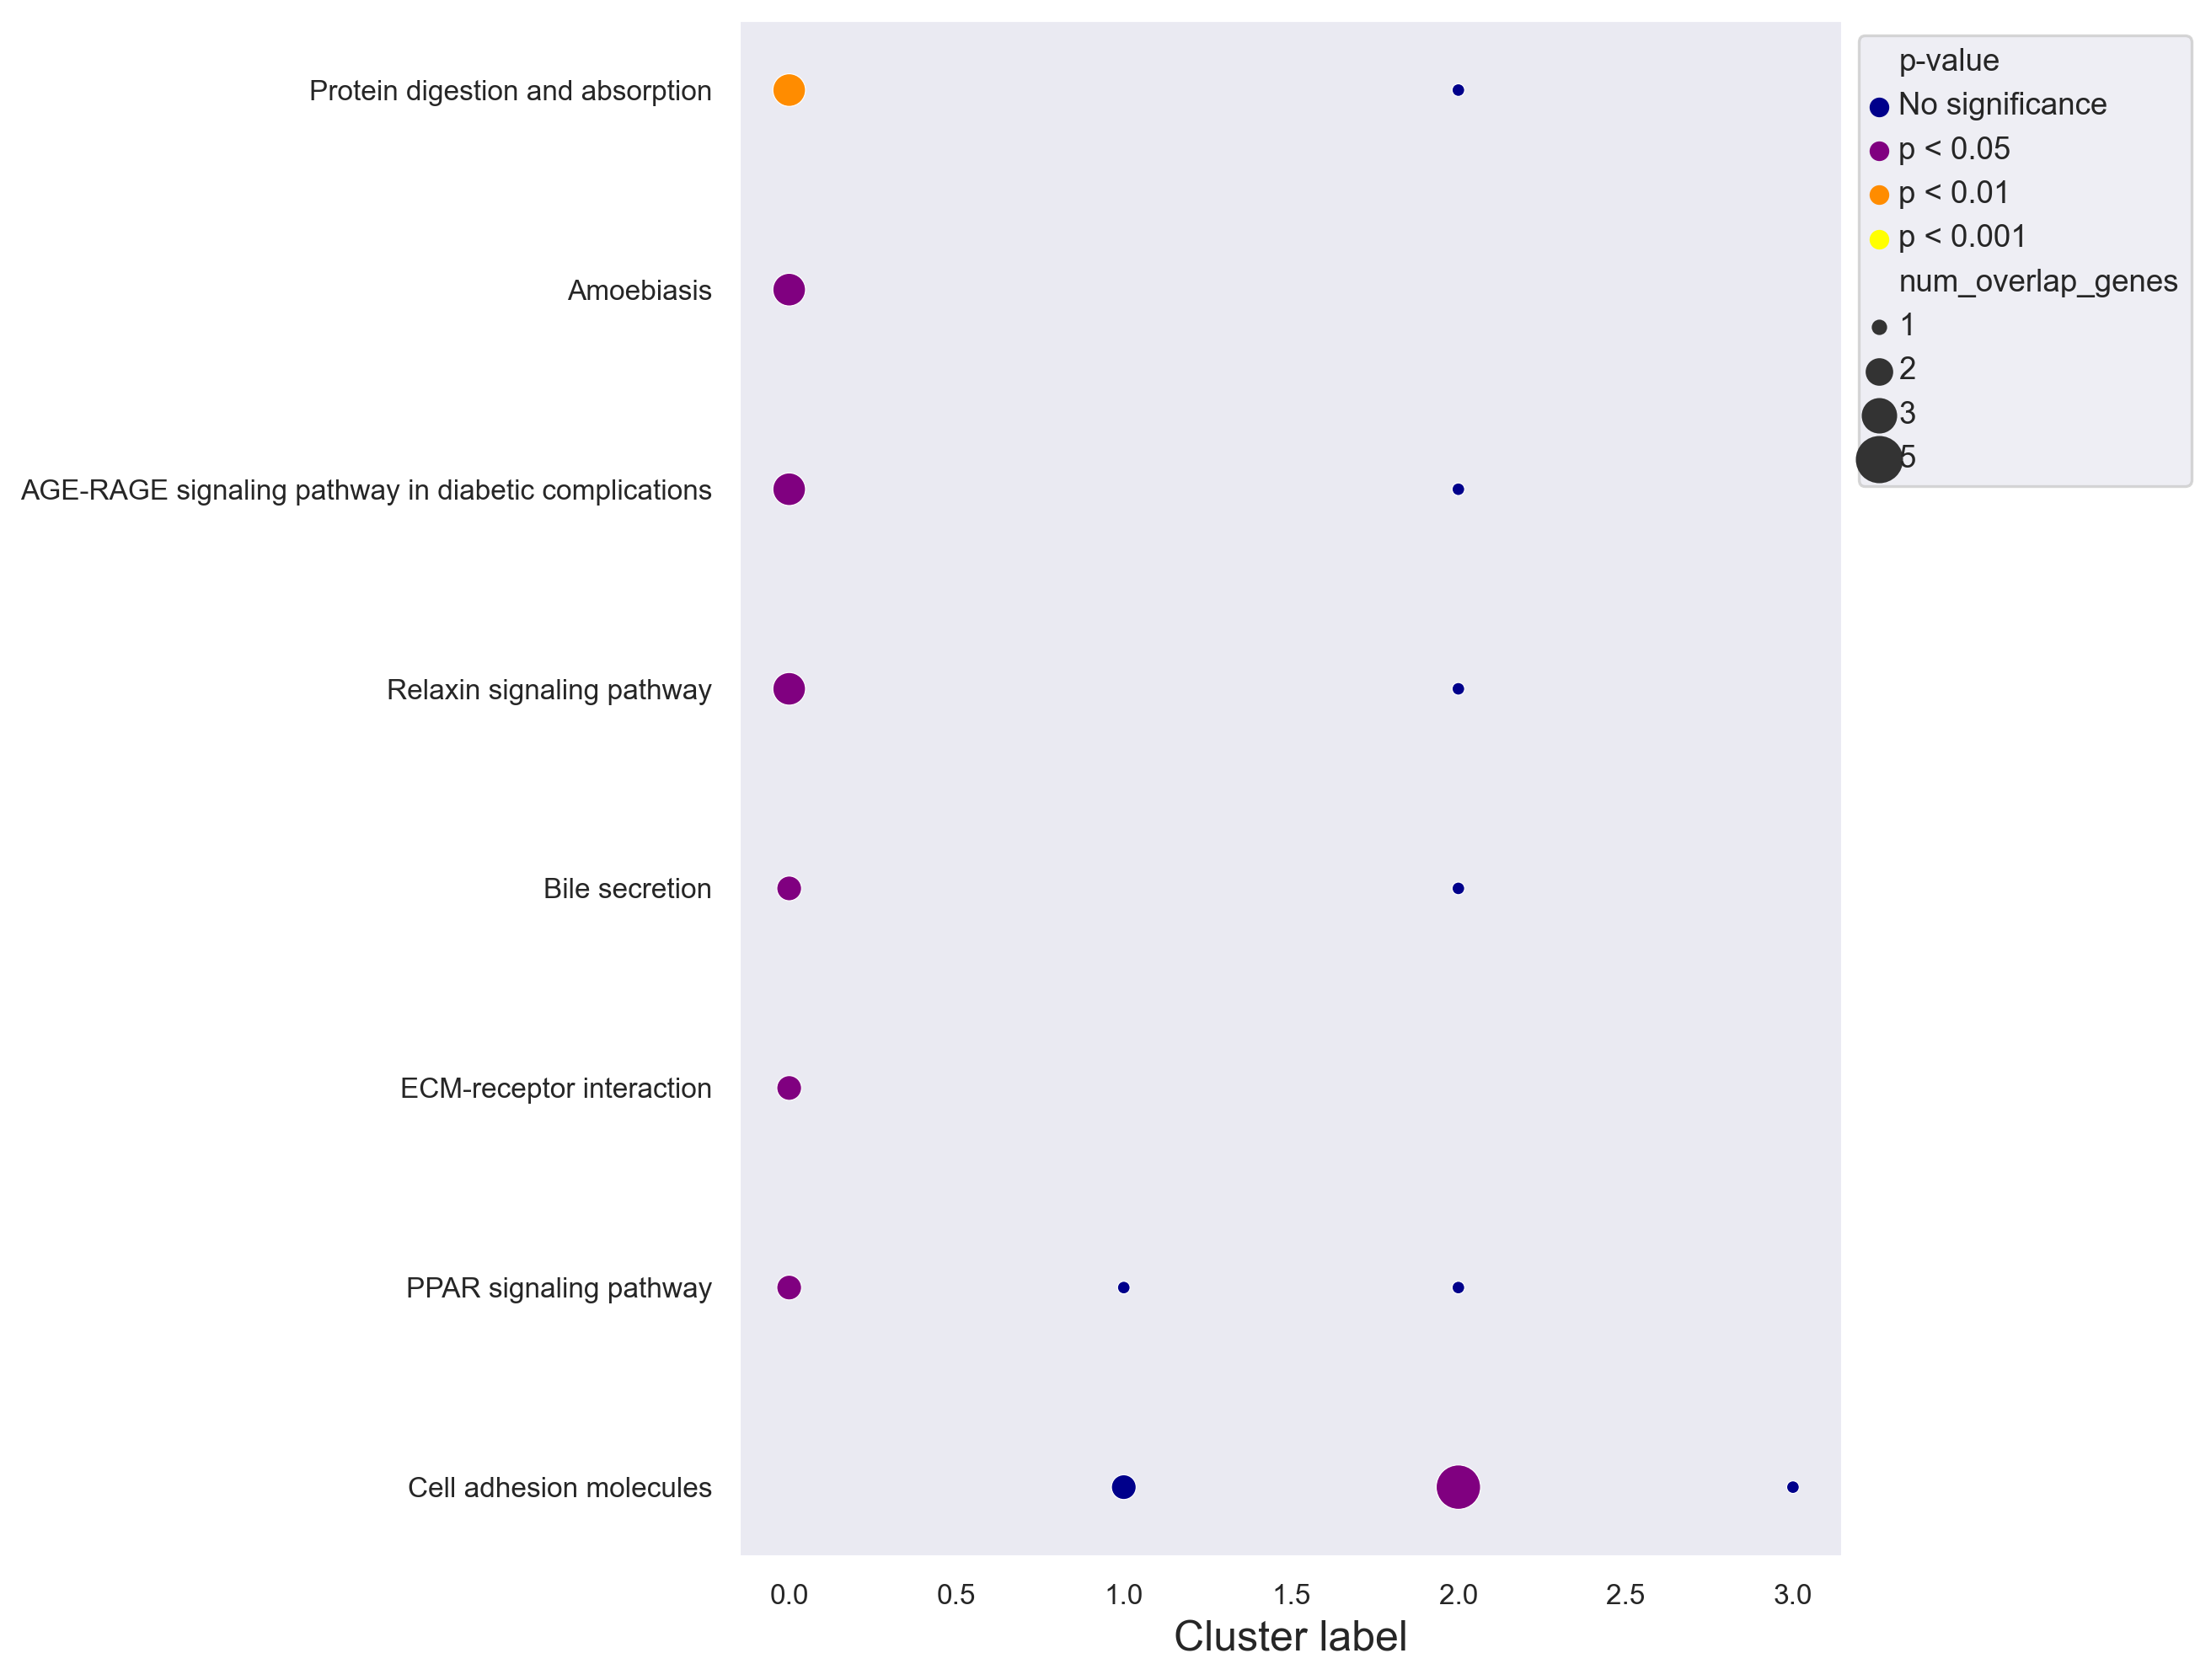

In [69]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))